- df_rfm : rfm을 적용한 구매 내역이 있는 고객
- rfmSegmentation : rfm을 구한 데이터

In [1]:
# 데이터 구성 패키지
import pandas as pd

# 행렬 연산 패키지
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt

# scaling 클래스
from sklearn.preprocessing import scale, minmax_scale, robust_scale

#jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

In [2]:
# 한글 깨짐 해결 : unicode minus를 사용하지 않기 위한 설정(minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

# 한글 폰트(나눔 고딕) 적용
from matplotlib import font_manager as fm
font_name = fm.FontProperties(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf').get_name()
matplotlib.rc("font", family=font_name)

In [3]:
df_mem = pd.read_csv("jeju_member.csv", engine = "python", encoding = "utf-8")

# taltoi_date, ri, address drop 
df_mem = df_mem.drop(["taltoi_date","ri", "address"], axis=1, inplace=False)
df_mem.head()

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
0,C102666,1976-11-08,남,44,40대,일반,3Gold,2014-10-07,63,매장,Y,Y,Y,Y,690-170,제주시,연동
1,C118113,1975-08-18,여,45,40대,일반,3Gold,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
2,C118133,1981-03-20,남,39,30대,일반,4Silver,2011-12-07,28,매장,N,Y,Y,N,699-900,서귀포시,성산읍
3,C118278,1979-06-22,여,41,40대,일반,3Gold,2011-12-11,97,인터넷,Y,Y,Y,Y,695-791,제주시,애월읍
4,C118280,1959-08-28,남,61,60대,일반,3Gold,2011-12-11,53,기타,N,N,N,N,699-905,서귀포시,성산읍


In [4]:
df_sales = pd.read_csv("jeju_sales.csv", engine = "python", encoding = "utf-8")
df_sales.head()

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000


In [5]:
# unit_cost 가격을 2018년도 가격으로 맞추기. 
df_sales.loc[(df_sales["item_name"]=='미니단호박(무/800g이상/2~3개)-제주' )&(df_sales["unit_cost"]==0 ), 'unit_cost'] = 4500

df_sales[(df_sales["item_name"]=='미니단호박(무/800g이상/2~3개)-제주' ) & (df_sales["purchase_id"]=='C463546_20180713_38')]

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
130296,C463546,C463546_20180713_38,제주매장,2018M07,금요일,12,2018-07-13,:0:12:31:43,2018-07-13,P05021002,채소,열매채소,미니단호박,미니단호박(무/800g이상/2~3개)-제주,1,4500,0


In [6]:
# purchase_cnt = 0 -> 분석에서 제외 
idx = df_sales.loc[df_sales['purchase_cnt']==0, ].index
df_sales = df_sales.drop(idx)

In [7]:
# purchase_amt 이상치 처리 => amt 재계산
df_amt = df_sales
df_amt.loc[df_amt['purchase_cnt']!=0, 'purchase_amt'] = (df_amt['purchase_cnt']*df_amt['unit_cost'])

df_sales = df_amt
df_sales

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273317,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P01010104,주곡,멥쌀,백미,백미/유(4kg)-매장용,1,15700,15700
273318,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P08010301,간식,과자,한과/유과,차례상약과(350g/10개),1,8800,8800
273319,C705016,C705016_20191222_46,서귀포매장,2019M12,일요일,14,2019-12-22,:0:14:52:43,2019-12-22,P06040300,축산물,유제품,아이스크림,유기농아이스크림(기본형),1,8900,8900
273320,C705016,C705016_20191229_51,서귀포매장,2019M12,일요일,14,2019-12-29,:0:14:53:30,2019-12-29,P08040137,간식,빵,빵,쌀로만든잉글리쉬머핀(66g×4개)/매장,1,3900,3900


In [8]:
df_sales_filter = df_sales[(df_sales["purchase_cnt"] < 6)]
df_sales = df_sales_filter

In [9]:
df_member = df_mem
df_member.loc[df_mem['customer_grade'] =='1Royal', 'customer_grade'] = 'Royal'
df_member.loc[df_mem['customer_grade'] =='2Platinum', 'customer_grade'] = 'Platinum'
df_member.loc[df_mem['customer_grade'] =='3Gold', 'customer_grade'] = 'Gold'
df_member.loc[df_mem['customer_grade'] =='4Silver', 'customer_grade'] ='Silver'
df_mem = df_member
df_mem

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
0,C102666,1976-11-08,남,44,40대,일반,Gold,2014-10-07,63,매장,Y,Y,Y,Y,690-170,제주시,연동
1,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,Y,Y,Y,Y,690-122,제주시,아라2동
2,C118133,1981-03-20,남,39,30대,일반,Silver,2011-12-07,28,매장,N,Y,Y,N,699-900,서귀포시,성산읍
3,C118278,1979-06-22,여,41,40대,일반,Gold,2011-12-11,97,인터넷,Y,Y,Y,Y,695-791,제주시,애월읍
4,C118280,1959-08-28,남,61,60대,일반,Gold,2011-12-11,53,기타,N,N,N,N,699-905,서귀포시,성산읍
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6008,C705804,1962-08-13,여,58,50대,일반,Platinum,2019-12-09,1,인터넷,Y,Y,Y,Y,697-070,서귀포시,동홍동
6009,C706457,1995-10-12,여,25,20대,일반,Silver,2019-12-11,1,인터넷,Y,Y,Y,N,690-781,제주시,화북일동
6010,C707942,1986-09-20,여,34,30대,일반,Silver,2019-12-19,1,인터넷,Y,Y,N,Y,695-964,제주시,조천읍
6011,C707954,1984-04-20,여,36,30대,일반,Gold,2019-12-19,1,인터넷,Y,N,N,N,690-806,제주시,도남동


### RFM을 이용하여 등급 재조정

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
df_sales.head()

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt
0,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P08010117,간식,과자,스낵,꼬마찹쌀모나카(112g/8개),1,3000,3000
1,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040101,양념/가루,장,간장,제주전통어간장(500ml),1,7900,7900
2,C118113,C118113_20180110_87,제주매장,2018M01,수요일,14,2018-01-10,:0:14:47:04,2018-01-10,P09040100,양념/가루,장,간장,맛간장(900ml),1,13600,13600
3,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010305,양념/가루,가루,곡식가루,엿기름가루(무/500g),2,3200,6400
4,C118113,C118113_20181008_22,제주매장,2018M10,월요일,11,2018-10-08,:0:11:59:24,2018-10-08,P09010301,양념/가루,가루,곡식가루,메주가루(500g),2,11000,22000


In [12]:
# df_torders : temp
# df_orders : 19년도 10월 ~ 12월 구매이력이 있는 데이터
df_torders = df_sales.groupby(['customer_id','purchase_id','purchase_date'])['purchase_amt'].sum().reset_index()
df_orders = df_torders[df_torders['purchase_date']>='2019-10-01']
df_orders

,customer_id,purchase_id,purchase_date,purchase_amt
24,C118291,C118291_20191010_142,2019-10-10,20700
25,C118291,C118291_20191024_78,2019-10-24,31500
26,C118291,C118291_20191104_15,2019-11-04,21700
27,C118291,C118291_20191113_169,2019-11-13,12600
28,C118291,C118291_20191115_124,2019-11-15,10900
...,...,...,...,...
66231,C704271,C704271_20191220_139,2019-12-20,6500
66232,C704271,C704271_20191221_57,2019-12-21,7900
66233,C704612,C704612_20191220_35,2019-12-20,10800
66234,C705016,C705016_20191222_46,2019-12-22,33400


In [13]:
import datetime as dt
# 2020년 1월 1일 기준
NOW = dt.datetime(2020,1,1)

In [14]:
# 2020-01-01을 기준으로 구매일자 차이 구하기
df_orders['purchase_date'] = pd.to_datetime(df_orders['purchase_date'])

In [15]:
# customer_id 별 방문횟수, 총 구매금액 구하기
rfmTable = df_orders.groupby('customer_id').agg({'purchase_date': lambda x: (NOW - x.max()).days, # Recency
                                        'purchase_id': lambda x: len(x),      # Frequency
                                        'purchase_amt': lambda x: x.sum()}) # Monetary Value

rfmTable['purchase_date'] = rfmTable['purchase_date'].astype(int)
rfmTable.rename(columns={'purchase_date': 'recency', 
                         'purchase_id': 'frequency', 
                         'purchase_amt': 'monetary_value'}, inplace=True)
rfmTable.head()

,recency,frequency,monetary_value
customer_id,,,
C118291,2,20,412050
C118294,45,2,16850
C118298,15,6,74650
C118300,44,1,87000
C118476,32,3,68400


In [16]:
# 25%씩 level만들기
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,7.0,1.0,14050.0
0.50,21.0,3.0,39800.0
0.75,44.0,6.0,104350.0


In [17]:
quantiles = quantiles.to_dict()
quantiles

{'recency': {0.25: 7.0, 0.5: 21.0, 0.75: 44.0},
 'frequency': {0.25: 1.0, 0.5: 3.0, 0.75: 6.0},
 'monetary_value': {0.25: 14050.0, 0.5: 39800.0, 0.75: 104350.0}}

In [18]:
rfmSegmentation = rfmTable


In [19]:
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [20]:
rfmSegmentation['R_Quartile'] = rfmSegmentation['recency'].apply(RClass, args=('recency',quantiles,))
rfmSegmentation['F_Quartile'] = rfmSegmentation['frequency'].apply(FMClass, args=('frequency',quantiles,))
rfmSegmentation['M_Quartile'] = rfmSegmentation['monetary_value'].apply(FMClass, args=('monetary_value',quantiles,))
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile
customer_id,,,,,,
C118291,2,20,412050,4,4,4
C118294,45,2,16850,1,2,2
C118298,15,6,74650,3,3,3
C118300,44,1,87000,2,1,3
C118476,32,3,68400,2,2,3
...,...,...,...,...,...,...
C704198,6,4,49850,4,3,3
C704239,2,1,18900,4,1,2
C704271,11,5,43800,3,3,3


In [21]:
# 가중치 0.1, 0.1, 0.8로 계산
rfmSegmentation['Class'] = (0.3*rfmSegmentation['R_Quartile']) \
                            + (0.3*rfmSegmentation['F_Quartile']) \
                            + (0.4*rfmSegmentation['M_Quartile'])
rfmSegmentation

,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
customer_id,,,,,,,
C118291,2,20,412050,4,4,4,4.0
C118294,45,2,16850,1,2,2,1.7
C118298,15,6,74650,3,3,3,3.0
C118300,44,1,87000,2,1,3,2.1
C118476,32,3,68400,2,2,3,2.4
...,...,...,...,...,...,...,...
C704198,6,4,49850,4,3,3,3.3
C704239,2,1,18900,4,1,2,2.3
C704271,11,5,43800,3,3,3,3.0


In [22]:
# 10% 20% 40% 30% (Royal, Platinum, Gold, Silver)
rfmSegmentation.quantile(q=0.85, interpolation='nearest')

recency               62.0
frequency             10.0
monetary_value    166395.0
R_Quartile             4.0
F_Quartile             4.0
M_Quartile             4.0
Class                  3.7
Name: 0.85, dtype: float64

In [23]:
import copy

# 가중치 계산한 값을 멤버십등급으로 바꿔주기
df_tmp = copy.deepcopy(rfmSegmentation)

# df_tmp['Class'] = df_tmp['Class'].astype(object)
df_tmp.loc[rfmSegmentation['Class'] >=3.7, 'Class'] = 1
df_tmp.loc[(rfmSegmentation['Class'] <3.7)& (rfmSegmentation['Class'] >2.3), 'Class'] = 2
df_tmp.loc[(rfmSegmentation['Class'] <=2.3)&(rfmSegmentation['Class'] >1.0), 'Class'] = 3
df_tmp.loc[rfmSegmentation['Class'] ==1.0, 'Class'] =4

df_tmp


,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
customer_id,,,,,,,
C118291,2,20,412050,4,4,4,1.0
C118294,45,2,16850,1,2,2,3.0
C118298,15,6,74650,3,3,3,2.0
C118300,44,1,87000,2,1,3,3.0
C118476,32,3,68400,2,2,3,2.0
...,...,...,...,...,...,...,...
C704198,6,4,49850,4,3,3,2.0
C704239,2,1,18900,4,1,2,3.0
C704271,11,5,43800,3,3,3,2.0


In [24]:
# 멤버십 등급 이름으로 바꾸기

rfmSegmentation['Class'] = df_tmp['Class'].astype(object)
rfmSegmentation.loc[df_tmp['Class'] == 1.0, 'Class'] = "Royal"
rfmSegmentation.loc[df_tmp['Class'] == 2.0, 'Class'] = "Platinum"
rfmSegmentation.loc[df_tmp['Class'] == 3.0, 'Class'] = "Gold"
rfmSegmentation.loc[df_tmp['Class'] == 4.0, 'Class'] ="Silver"


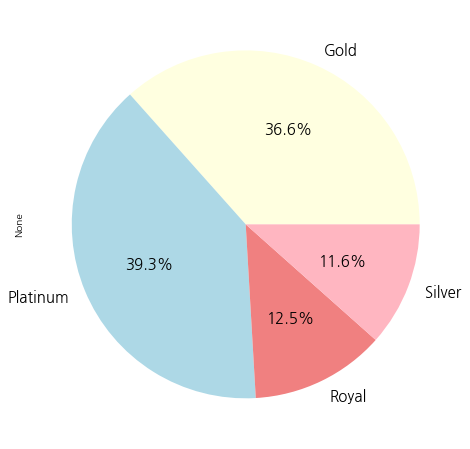

In [25]:
# rfm 등급비율

group_colors = ['lightyellow', 'lightblue', 'lightcoral','lightpink']

df_count = rfmSegmentation.groupby(["Class"]).size()
df_count.plot(figsize=(8,8), kind = "pie",autopct = "%.1f%%", fontsize = 15, colors = group_colors)

In [26]:
df_count

Class
Gold        585
Platinum    629
Royal       200
Silver      185
dtype: int64

##### 등급 재조정 후 등급이 바뀐 수 찾기

In [28]:
# 모든 고객의 구매 내역(없으면 NaN)
df_mge = pd.merge(df_mem, df_sales,on=['customer_id'],how='left')

# 구매내역이 없는 고객일 경우 제거
df_mge = df_mge[df_mge['purchase_amt'].notnull()]

# rfm 적용한 구매내역이 있는 고객
df_rfm = pd.merge(df_mge, rfmSegmentation,on=['customer_id'],how='left')
df_rfm

,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,gaip_path,...,purchase_cnt,unit_cost,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
0,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,...,1.0,3000.0,3000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,...,1.0,7900.0,7900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,...,1.0,13600.0,13600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,...,2.0,3200.0,6400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C118113,1975-08-18,여,45,40대,일반,Gold,2011-12-06,97,기타,...,2.0,11000.0,22000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271017,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,인터넷,...,1.0,15700.0,15700.0,3.0,2.0,41800.0,4.0,2.0,3.0,Platinum
271018,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,인터넷,...,1.0,8800.0,8800.0,3.0,2.0,41800.0,4.0,2.0,3.0,Platinum
271019,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,인터넷,...,1.0,8900.0,8900.0,3.0,2.0,41800.0,4.0,2.0,3.0,Platinum
271020,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,인터넷,...,1.0,3900.0,3900.0,3.0,2.0,41800.0,4.0,2.0,3.0,Platinum


In [29]:
df_change = df_rfm.groupby(['customer_id', 'customer_grade', 'Class'])['purchase_amt'].sum().reset_index()
df_change

,customer_id,customer_grade,Class,purchase_amt
0,C118291,Royal,Royal,1062850.0
1,C118294,Platinum,Gold,165000.0
2,C118298,Platinum,Platinum,526300.0
3,C118300,Royal,Gold,128200.0
4,C118476,Gold,Platinum,667140.0
...,...,...,...,...
1594,C704198,Platinum,Platinum,49850.0
1595,C704239,Gold,Gold,18900.0
1596,C704271,Platinum,Platinum,43800.0
1597,C704612,Gold,Gold,10800.0


In [30]:
df_change[df_change['customer_grade']!=df_change['Class']]

,customer_id,customer_grade,Class,purchase_amt
1,C118294,Platinum,Gold,165000.0
3,C118300,Royal,Gold,128200.0
4,C118476,Gold,Platinum,667140.0
5,C118477,Platinum,Gold,661800.0
6,C118530,Gold,Silver,256350.0
...,...,...,...,...
1585,C701957,Gold,Platinum,72800.0
1586,C701961,Gold,Platinum,76800.0
1588,C701974,Gold,Platinum,165000.0
1591,C703481,Gold,Platinum,117000.0


In [31]:
df_re = df_change.groupby(['customer_grade','Class'])['purchase_amt'].count().reset_index()
df_re.rename(columns = {'customer_grade':'Before', 'Class':'After', 'purchase_amt':'Count'}, inplace = True)
df_re

,Before,After,Count
0,Gold,Gold,358
1,Gold,Platinum,306
2,Gold,Royal,47
3,Gold,Silver,118
4,Platinum,Gold,177
5,Platinum,Platinum,288
6,Platinum,Royal,101
7,Platinum,Silver,35
8,Royal,Gold,5
9,Royal,Platinum,27


##### 등급별 객단가

In [33]:
# 고객별 구매총합 (rfm 적용)
df_rfm_sum = df_rfm.groupby(['purchase_id','Class'])['purchase_amt'].sum().reset_index()

df_rfm_sum

,purchase_id,Class,purchase_amt
0,C118291_20180209_98,Royal,18200.0
1,C118291_20180210_30,Royal,39000.0
2,C118291_20180216_109,Royal,14200.0
3,C118291_20180228_132,Royal,20450.0
4,C118291_20180725_157,Royal,12900.0
...,...,...,...
59686,C704271_20191220_139,Platinum,6500.0
59687,C704271_20191221_57,Platinum,7900.0
59688,C704612_20191220_35,Gold,10800.0
59689,C705016_20191222_46,Platinum,33400.0


      Class  purchase_amt
0      Gold  18619.045702
1  Platinum  21925.011678
2     Royal  24604.381386
3    Silver  15895.880106


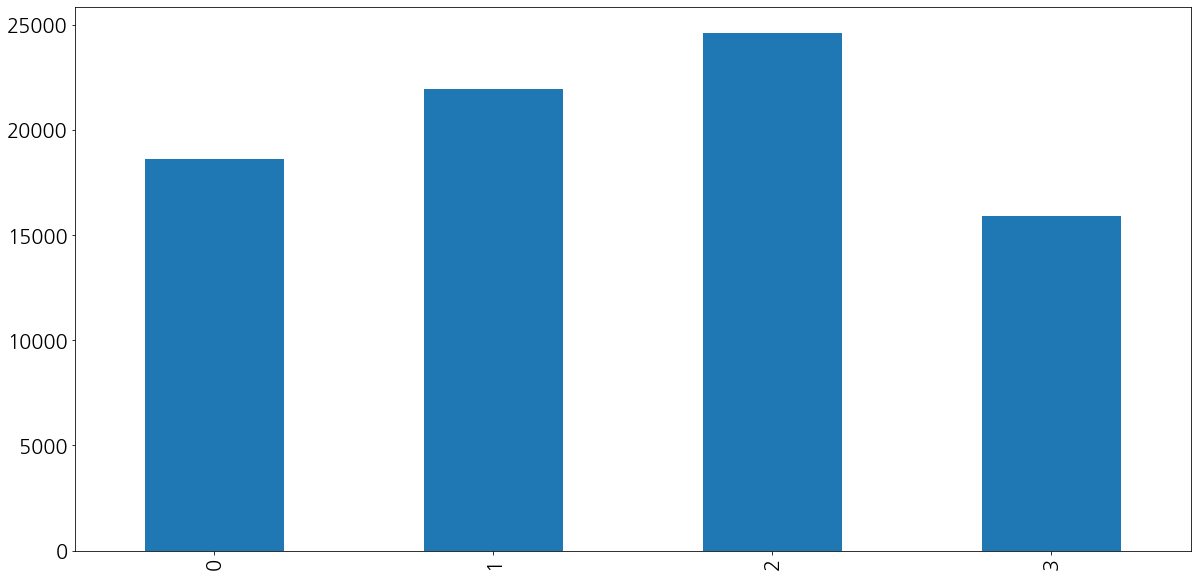

In [34]:
# rfm 적용한 객단가 
df_rfm_bar = df_rfm_sum.groupby(['Class'])['purchase_amt'].mean().reset_index()
df_rfm_bar['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_rfm_bar)

##### RFM 적용전 등급 비율과 객단가 

In [35]:
# rfm 적용 안한 등급 비율과 객단가 구하자.
df_mmsales = pd.merge(df_sales, df_mem,on=['customer_id'],how='left')

df_msales = df_mmsales[df_mmsales['purchase_date']>='2019-10-01']
df_msales = df_msales.groupby(['customer_id', 'customer_grade']).sum().reset_index()
df_msales

,customer_id,customer_grade,purchase_hour,purchase_cnt,unit_cost,purchase_amt,age,member_month
0,C118291,Royal,1153,77,384450,412050,4176,6984
1,C118294,Platinum,80,8,10500,16850,235,485
2,C118298,Platinum,252,24,62800,74650,1292,1843
3,C118300,Royal,50,7,81000,87000,270,485
4,C118476,Gold,157,10,66150,68400,513,873
...,...,...,...,...,...,...,...,...
1594,C704198,Platinum,150,30,24950,49850,585,15
1595,C704239,Gold,36,3,18900,18900,156,3
1596,C704271,Platinum,150,11,36800,43800,480,10
1597,C704612,Gold,11,4,2700,10800,51,1


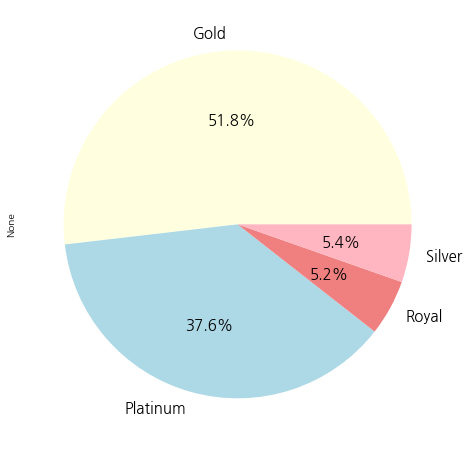

In [36]:
df_count = df_msales.groupby(["customer_grade"]).size()
group_colors = ['lightyellow', 'lightblue', 'lightcoral','lightpink']
df_count.plot(figsize=(8,8), kind = "pie",autopct = "%.1f%%", fontsize = 15, colors = group_colors)

In [37]:
df_count

customer_grade
Gold        829
Platinum    601
Royal        83
Silver       86
dtype: int64

In [38]:
df_mmsales = pd.merge(df_sales, df_mem,on=['customer_id'],how='left')
df_msales = df_mmsales[df_mmsales['purchase_date']>='2019-10-01']

df_gag = df_msales.groupby(['customer_grade','purchase_id'])['purchase_amt'].sum().reset_index()
df_ori = df_gag.groupby(['customer_grade'])['purchase_amt'].mean().reset_index()


  customer_grade  purchase_amt
0           Gold  15177.799396
1       Platinum  16673.217693
2          Royal  20971.736021
3         Silver  12940.430464


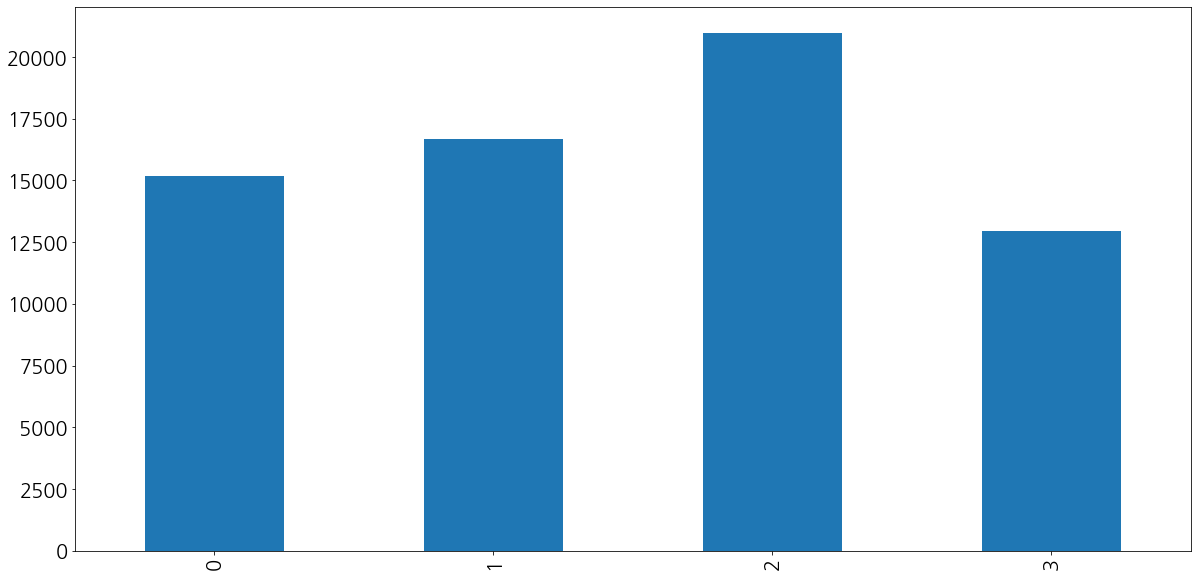

In [39]:
df_ori['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_ori)

##### 등급 재조정 후와 조정전 각 등급 인원 수 비교 

In [40]:
# RFM 적용한 각 인원수 구하기
df_rfm_tmp = df_rfm.groupby(['Class','customer_id'])['purchase_amt'].sum().reset_index()
df_rfm_tmp

,Class,customer_id,purchase_amt
0,Gold,C118294,165000.0
1,Gold,C118300,128200.0
2,Gold,C118477,661800.0
3,Gold,C119580,254500.0
4,Gold,C119611,376150.0
...,...,...,...
1594,Silver,C694958,11700.0
1595,Silver,C694963,2850.0
1596,Silver,C695624,11000.0
1597,Silver,C696818,3200.0


In [41]:
df_rfm_count = df_rfm_tmp.groupby(['Class'])['customer_id'].count().reset_index()
df_rfm_count = df_rfm_count.rename(columns={'Class':'Grade', 'customer_id':'Count'})

In [42]:
# 각 등급별 인원수
df_merge_tmp = df_msales.groupby(['customer_grade','customer_id'])['purchase_amt'].sum().reset_index()
df_merge_tmp

,customer_grade,customer_id,purchase_amt
0,Gold,C118476,68400
1,Gold,C118530,3900
2,Gold,C119301,45460
3,Gold,C119580,24350
4,Gold,C121157,92800
...,...,...,...
1594,Silver,C692097,142500
1595,Silver,C692374,26550
1596,Silver,C696818,3200
1597,Silver,C697473,12150


In [43]:
df_merge_count = df_merge_tmp.groupby(['customer_grade'])['customer_id'].count().reset_index()
df_merge_count = df_merge_count.rename(columns={'customer_grade':'Grade', 'customer_id':'Count'})

In [44]:
display(df_rfm_count, df_merge_count)

,Grade,Count
0,Gold,585
1,Platinum,629
2,Royal,200
3,Silver,185


,Grade,Count
0,Gold,829
1,Platinum,601
2,Royal,83
3,Silver,86


### ROYAL을 기준으로 탐색적 분석 

In [48]:
# Royal만 나타내기
df_r = rfmSegmentation[rfmSegmentation['Class']=='Royal']
df_royal = pd.merge(df_sales, df_r, on=['customer_id'], how='left')
df_royal = df_royal[df_royal['Class'].notnull()]
df_royal

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,purchase_cnt,unit_cost,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
9,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P10020105,...,1,1800,1800,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
10,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P06030301,...,1,9800,9800,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
11,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P08010116,...,1,6600,6600,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
12,C118291,C118291_20180210_30,제주매장,2018M02,토요일,13,2018-02-10,:0:13:24:36,2018-02-10,P08010302,...,1,39000,39000,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
13,C118291,C118291_20180216_109,제주매장,2018M02,금요일,17,2018-02-16,:0:17:54:11,2018-02-16,P10030501,...,2,2100,4200,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270789,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010201,...,1,3300,3300,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270790,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010101,...,1,4000,4000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270791,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P08020203,...,2,3000,6000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270792,C700358,C700358_20191230_22,제주매장,2019M12,월요일,11,2019-12-30,:0:11:26:20,2019-12-30,P05030122,...,2,10500,21000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal


##### 선호하는 요일 

In [49]:
# 선호요일
df_week = df_royal.groupby(['customer_id','purchase_id','purchase_weekday'])['purchase_amt'].count().reset_index()
df_week

,customer_id,purchase_id,purchase_weekday,purchase_amt
0,C118291,C118291_20180209_98,금요일,3
1,C118291,C118291_20180210_30,토요일,1
2,C118291,C118291_20180216_109,금요일,4
3,C118291,C118291_20180228_132,수요일,7
4,C118291,C118291_20180725_157,수요일,3
...,...,...,...,...
22956,C700358,C700358_20191209_75,월요일,1
22957,C700358,C700358_20191212_118,목요일,2
22958,C700358,C700358_20191219_89,목요일,2
22959,C700358,C700358_20191220_114,금요일,4


In [50]:
# groupby 전 값 미리 확인해보기
df_week[(df_week['customer_id']=='C118291')&(df_week['purchase_weekday']=="금요일")]

,customer_id,purchase_id,purchase_weekday,purchase_amt
0,C118291,C118291_20180209_98,금요일,3
2,C118291,C118291_20180216_109,금요일,4
5,C118291,C118291_20180810_100,금요일,9
6,C118291,C118291_20180831_23,금요일,6
25,C118291,C118291_20191115_124,금요일,1
33,C118291,C118291_20191206_149,금요일,7
34,C118291,C118291_20191206_151,금요일,1


In [51]:
df_week = df_week.groupby(['customer_id','purchase_weekday'])['purchase_amt'].count().reset_index()
df_week

,customer_id,purchase_weekday,purchase_amt
0,C118291,금요일,7
1,C118291,목요일,8
2,C118291,수요일,6
3,C118291,월요일,7
4,C118291,토요일,10
...,...,...,...
1329,C700358,수요일,1
1330,C700358,월요일,3
1331,C700358,일요일,1
1332,C700358,토요일,1


  purchase_weekday  purchase_amt
3              월요일          4217
0              금요일          3991
6              화요일          3726
1              목요일          3601
2              수요일          3588
5              토요일          2849
4              일요일           989


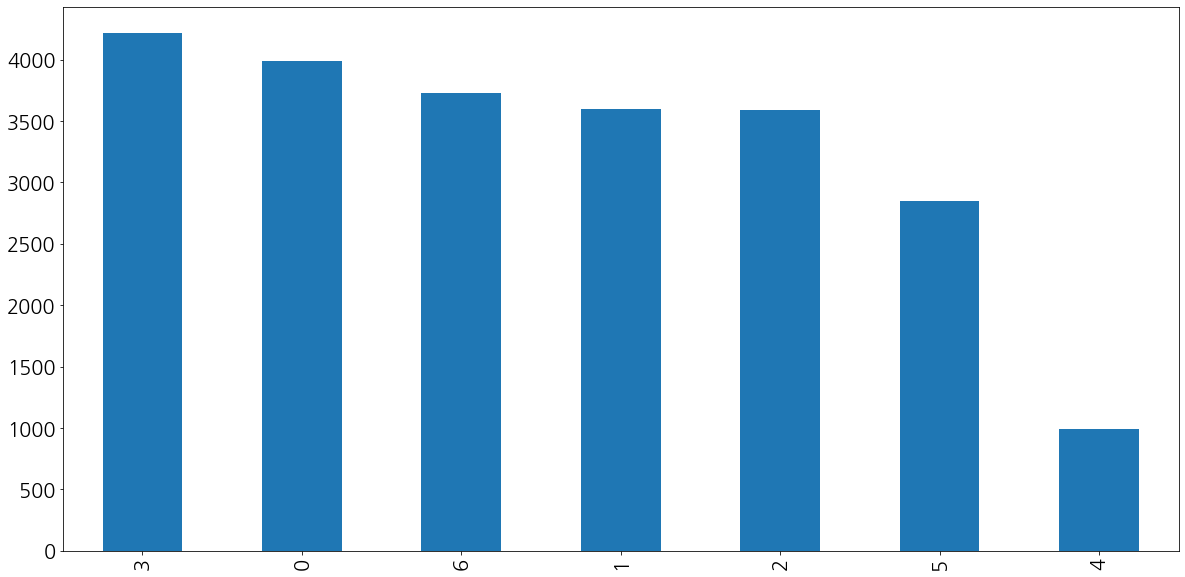

In [52]:
# bar chart로 확인
df_week_count = df_week.groupby(['purchase_weekday'])['purchase_amt'].sum().reset_index().sort_values(by='purchase_amt', ascending = False)
df_week_count['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_week_count)

##### 선호하는 매장 

In [53]:
# 선호매장 찾기
df_store = df_royal.groupby(['customer_id', 'purchase_id','store_id'])['purchase_amt'].count().reset_index()
df_store = df_store.groupby(['customer_id', 'store_id'])['purchase_id'].count().reset_index()
df_store

,customer_id,store_id,purchase_id
0,C118291,제주매장,41
1,C121449,모바일,38
2,C121449,인터넷,1
3,C121449,제주매장,54
4,C122517,서귀포매장,2
...,...,...,...
375,C694512,서귀포매장,2
376,C694512,제주매장,7
377,C694737,제주매장,13
378,C697539,제주매장,9


  store_id  purchase_id
4     제주매장        16554
1    서귀포매장         5358
2      인터넷          508
0      모바일          332
3       전화          209


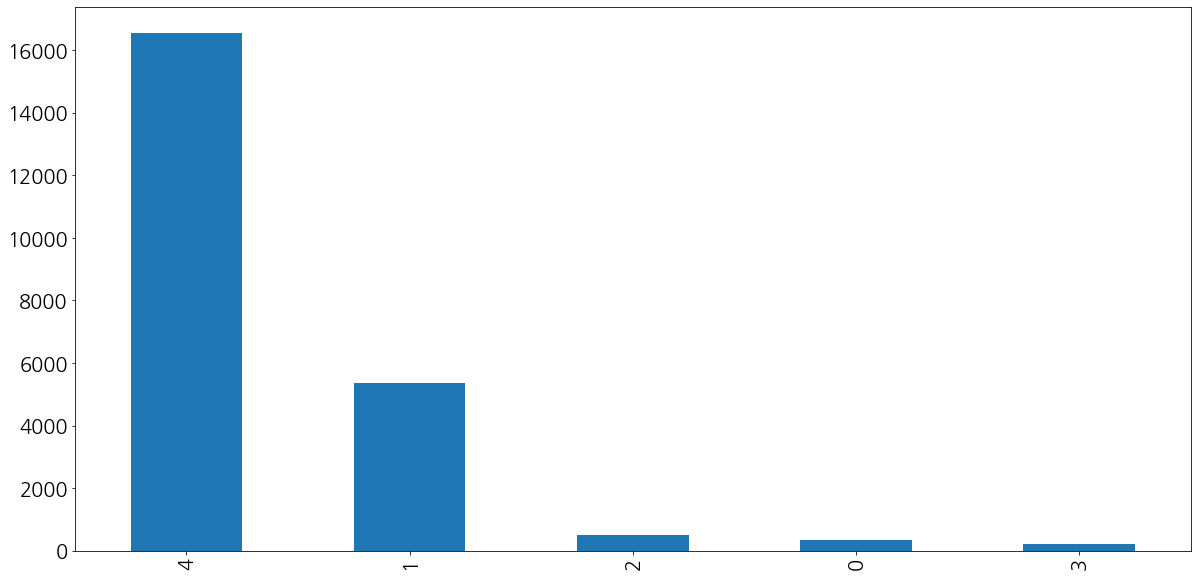

In [54]:
# bar chart로 확인
df_store_count = df_store.groupby(['store_id'])['purchase_id'].sum().reset_index().sort_values(by='purchase_id', ascending = False)
df_store_count['purchase_id'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_store_count)

##### 선호하는 구매시간

In [55]:
# 선호시간 구하기
df_hour = df_royal.groupby(['customer_id','purchase_id','purchase_hour'])['purchase_amt'].count().reset_index()
df_hour

,customer_id,purchase_id,purchase_hour,purchase_amt
0,C118291,C118291_20180209_98,16,3
1,C118291,C118291_20180210_30,13,1
2,C118291,C118291_20180216_109,17,4
3,C118291,C118291_20180228_132,18,7
4,C118291,C118291_20180725_157,18,3
...,...,...,...,...
23228,C700358,C700358_20191209_75,15,1
23229,C700358,C700358_20191212_118,17,2
23230,C700358,C700358_20191219_89,16,2
23231,C700358,C700358_20191220_114,16,4


In [56]:
df_hour = df_royal.groupby(['customer_id','purchase_hour'])['purchase_id'].count().reset_index()
df_hour

,customer_id,purchase_hour,purchase_id
0,C118291,10,13
1,C118291,11,5
2,C118291,12,4
3,C118291,13,9
4,C118291,14,5
...,...,...,...
2006,C700358,11,2
2007,C700358,14,4
2008,C700358,15,4
2009,C700358,16,23


    purchase_hour  purchase_id
0               0          181
1               1           84
2               2           11
3               3           17
4               5           70
5               6           53
6               7           59
7               8          155
8               9          597
9              10         7710
10             11        10640
11             12        10019
12             13         8447
13             14         7898
14             15         8957
15             16        12891
16             17        12052
17             18        10672
18             19        11504
19             20         1826
20             21          564
21             22          553
22             23          328


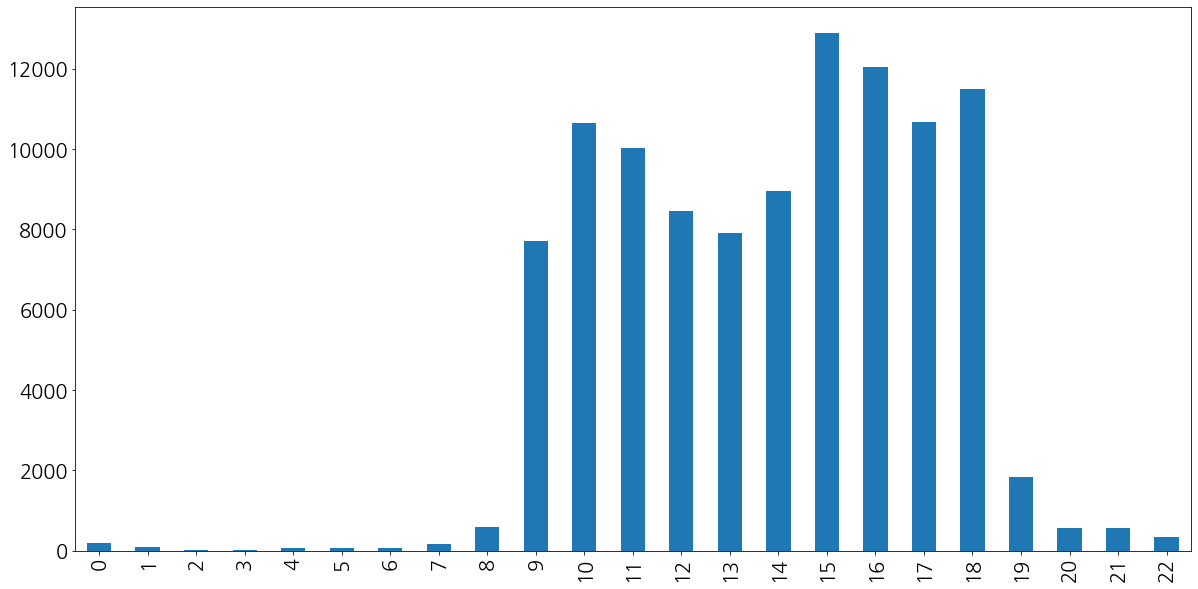

In [57]:
# bar chart로 확인
df_hour_count = df_hour.groupby(['purchase_hour'])['purchase_id'].sum().reset_index().sort_values(by='purchase_hour')
df_hour_count['purchase_id'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_hour_count)

### 온라인 / 오프라인 선호하는 구매 시간대 

In [58]:
# royal 회원의 유형 선호 시간대 
df_store_hour = df_royal.groupby(['customer_id','purchase_id','store_id','purchase_hour'])['purchase_amt'].count().reset_index()
df_store_hour

,customer_id,purchase_id,store_id,purchase_hour,purchase_amt
0,C118291,C118291_20180209_98,제주매장,16,3
1,C118291,C118291_20180210_30,제주매장,13,1
2,C118291,C118291_20180216_109,제주매장,17,4
3,C118291,C118291_20180228_132,제주매장,18,7
4,C118291,C118291_20180725_157,제주매장,18,3
...,...,...,...,...,...
23228,C700358,C700358_20191209_75,제주매장,15,1
23229,C700358,C700358_20191212_118,제주매장,17,2
23230,C700358,C700358_20191219_89,제주매장,16,2
23231,C700358,C700358_20191220_114,제주매장,16,4


##### 오프라인 

In [59]:
# royal 회원의 오프라인 선호 시간대(제주 + 서귀포매장)
df_mart = df_store_hour[(df_store_hour['store_id']=='제주매장')|(df_store_hour['store_id']=='서귀포매장')]
df_mart

,customer_id,purchase_id,store_id,purchase_hour,purchase_amt
0,C118291,C118291_20180209_98,제주매장,16,3
1,C118291,C118291_20180210_30,제주매장,13,1
2,C118291,C118291_20180216_109,제주매장,17,4
3,C118291,C118291_20180228_132,제주매장,18,7
4,C118291,C118291_20180725_157,제주매장,18,3
...,...,...,...,...,...
23228,C700358,C700358_20191209_75,제주매장,15,1
23229,C700358,C700358_20191212_118,제주매장,17,2
23230,C700358,C700358_20191219_89,제주매장,16,2
23231,C700358,C700358_20191220_114,제주매장,16,4


In [60]:
df_mart = df_mart.groupby(['customer_id','purchase_hour'])['purchase_amt'].count().reset_index()
df_mart

,customer_id,purchase_hour,purchase_amt
0,C118291,10,2
1,C118291,11,1
2,C118291,12,2
3,C118291,13,3
4,C118291,14,1
...,...,...,...
1831,C700358,11,1
1832,C700358,14,1
1833,C700358,15,4
1834,C700358,16,6


    purchase_hour  purchase_amt
0               8             1
1               9            58
2              10          1514
3              11          2100
4              12          2142
5              13          1881
6              14          1717
7              15          1967
8              16          2895
9              17          2723
10             18          2374
11             19          2459
12             20            81


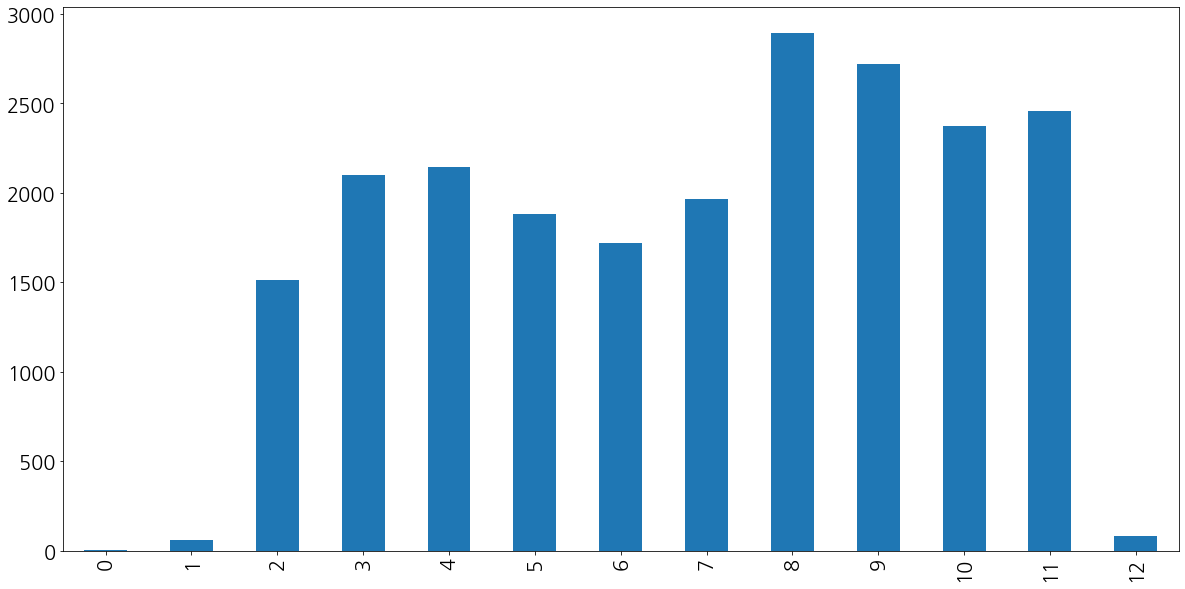

In [61]:
# bar chart로 확인
df_mart_count = df_mart.groupby(['purchase_hour'])['purchase_amt'].sum().reset_index().sort_values(by='purchase_hour')
df_mart_count['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_mart_count)

##### 전화 

In [62]:
# royal 회원의 전화주문 선호 시간대
df_call = df_store_hour[df_store_hour['store_id']=='전화']
df_call

,customer_id,purchase_id,store_id,purchase_hour,purchase_amt
595,C129286,C129286_20180101_201,전화,15,8
599,C129286,C129286_20180112_201,전화,11,11
601,C129286,C129286_20180122_201,전화,14,8
605,C129286,C129286_20180205_201,전화,11,12
608,C129286,C129286_20180219_201,전화,15,14
...,...,...,...,...,...
19513,C578709,C578709_20190909_180,전화,0,2
19975,C597622,C597622_20191003_180,전화,0,1
21667,C633223,C633223_20190910_180,전화,0,3
21968,C644185,C644185_20190513_201,전화,10,1


In [63]:
df_call = df_call.groupby(['customer_id','purchase_hour'])['purchase_amt'].count().reset_index()
df_call

,customer_id,purchase_hour,purchase_amt
0,C129286,0,2
1,C129286,9,1
2,C129286,11,3
3,C129286,12,1
4,C129286,13,1
5,C129286,14,5
6,C129286,15,11
7,C129286,16,8
8,C129286,18,1
9,C129286,22,1


    purchase_hour  purchase_amt
0               0             9
1               9            16
2              10            15
3              11            23
4              12            18
5              13            26
6              14            39
7              15            34
8              16            29
9              17            19
10             18             1
11             22             1


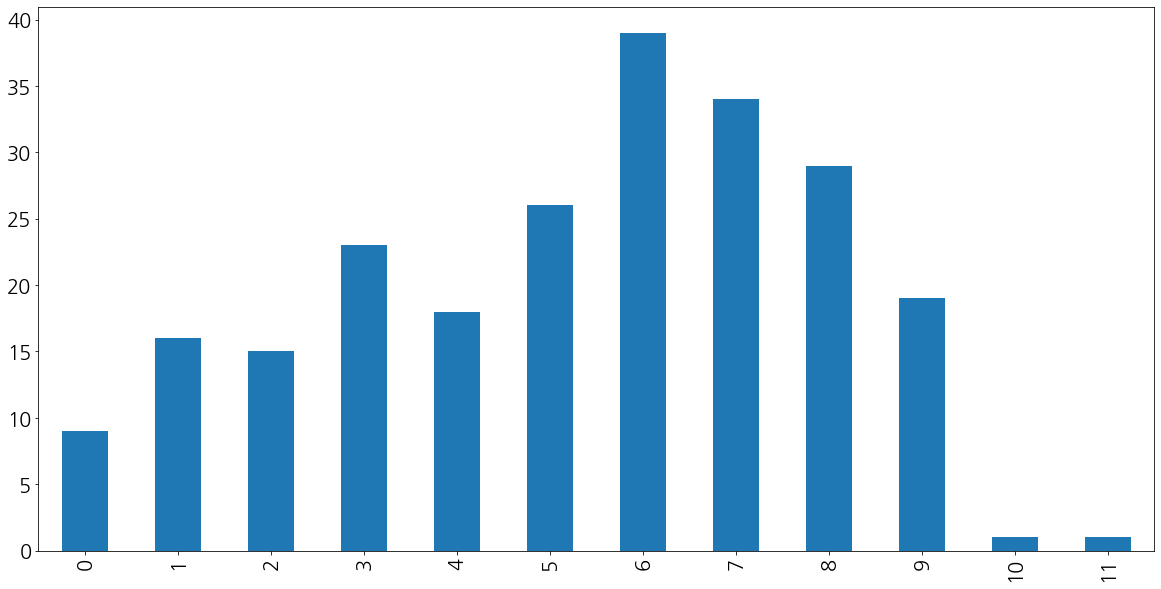

In [64]:
# bar chart로 확인
df_call_count = df_call.groupby(['purchase_hour'])['purchase_amt'].sum().reset_index().sort_values(by='purchase_hour')
df_call_count['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_call_count)

##### 온라인 

In [65]:
# royal 회원의 모바일 + 인터넷 선호 시간대
df_mob = df_store_hour[(df_store_hour['store_id']=='인터넷')|(df_store_hour['store_id']=='모바일')]
df_mob

,customer_id,purchase_id,store_id,purchase_hour,purchase_amt
51,C121449,C121449_20180307_201,모바일,12,17
72,C121449,C121449_20180608_201,모바일,18,12
76,C121449,C121449_20180614_201,모바일,9,1
95,C121449,C121449_20181205_201,모바일,9,1
96,C121449,C121449_20181205_201,모바일,23,10
...,...,...,...,...,...
23041,C688892,C688892_20190916_100,모바일,20,1
23044,C688892,C688892_20190930_100,모바일,17,4
23052,C688892,C688892_20191028_100,모바일,15,3
23053,C688892,C688892_20191028_100,모바일,18,1


In [66]:
df_mob = df_mob.groupby(['customer_id','purchase_hour'])['purchase_amt'].count().reset_index()
df_mob

,customer_id,purchase_hour,purchase_amt
0,C121449,0,1
1,C121449,9,5
2,C121449,10,3
3,C121449,11,1
4,C121449,12,3
...,...,...,...
301,C682607,21,1
302,C688892,15,1
303,C688892,17,1
304,C688892,18,1


    purchase_hour  purchase_amt
0               0            29
1               1            17
2               2             1
3               3             2
4               5             6
5               6             7
6               7             6
7               8            17
8               9            34
9              10            43
10             11            54
11             12            56
12             13            42
13             14            40
14             15            68
15             16            54
16             17            54
17             18            72
18             19           106
19             20           186
20             21            74
21             22            73
22             23            50


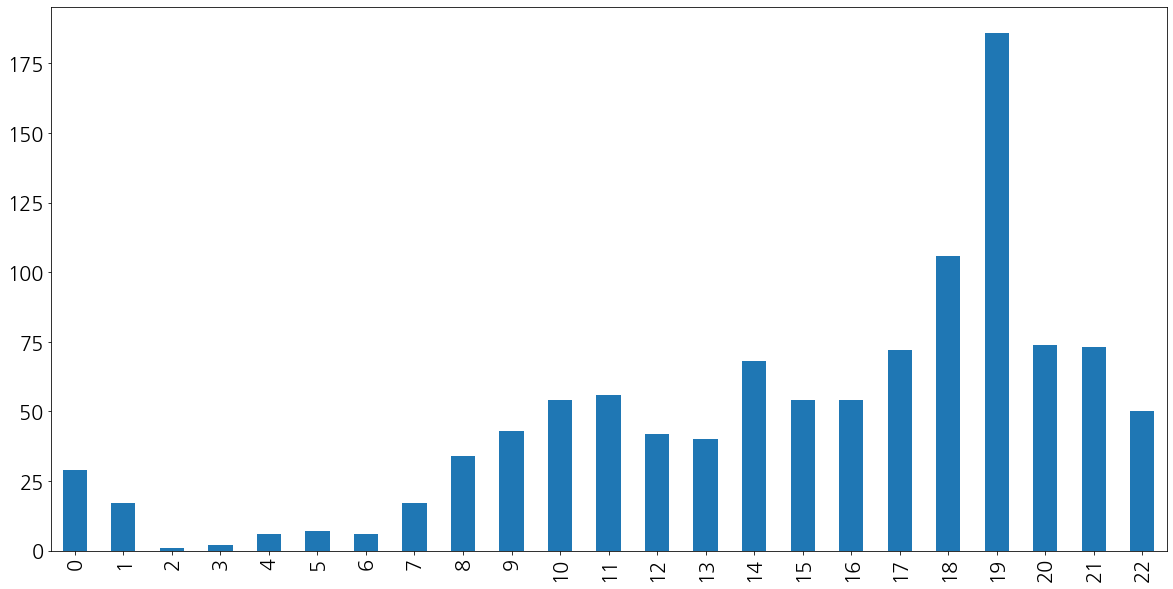

In [67]:
# bar chart로 확인
df_mob_count = df_mob.groupby(['purchase_hour'])['purchase_amt'].sum().reset_index().sort_values(by='purchase_hour')
df_mob_count['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_mob_count)

##### ROYAL 회원 연령대 확인 

In [68]:
df_royal_mem = pd.merge(df_royal, df_mem, on=['customer_id'],how='left')
df_royal_mem

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,gaip_date,member_month,gaip_path,flag_member,flag_rcv_sms,flag_rcv_email,flag_rcv_post,zipcode,sigun,dong
0,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P10020105,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
1,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P06030301,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
2,C118291,C118291_20180209_98,제주매장,2018M02,금요일,16,2018-02-09,:0:16:42:31,2018-02-09,P08010116,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
3,C118291,C118291_20180210_30,제주매장,2018M02,토요일,13,2018-02-10,:0:13:24:36,2018-02-10,P08010302,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
4,C118291,C118291_20180216_109,제주매장,2018M02,금요일,17,2018-02-16,:0:17:54:11,2018-02-16,P10030501,...,2011-12-11,97,기타,Y,Y,N,Y,690-760,제주시,노형동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105283,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010201,...,2019-11-11,2,인터넷,Y,Y,N,N,690-809,제주시,삼도2동
105284,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010101,...,2019-11-11,2,인터넷,Y,Y,N,N,690-809,제주시,삼도2동
105285,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P08020203,...,2019-11-11,2,인터넷,Y,Y,N,N,690-809,제주시,삼도2동
105286,C700358,C700358_20191230_22,제주매장,2019M12,월요일,11,2019-12-30,:0:11:26:20,2019-12-30,P05030122,...,2019-11-11,2,인터넷,Y,Y,N,N,690-809,제주시,삼도2동


In [69]:
df_royal_age = df_royal_mem.groupby(['customer_id', 'Class', 'agegroup'])['purchase_amt'].count().reset_index()
df_royal_age

,customer_id,Class,agegroup,purchase_amt
0,C118291,Royal,50대,164
1,C121449,Royal,40대,764
2,C122517,Royal,60대,544
3,C125805,Royal,40대,194
4,C126070,Royal,50대,1278
...,...,...,...,...
195,C694221,Royal,40대,91
196,C694512,Royal,30대,39
197,C694737,Royal,40대,69
198,C697539,Royal,30대,26


  agegroup  purchase_amt
0      20대             1
1      30대            34
2      40대            74
3      50대            53
4      60대            32
5      70대             5
6      80대             1


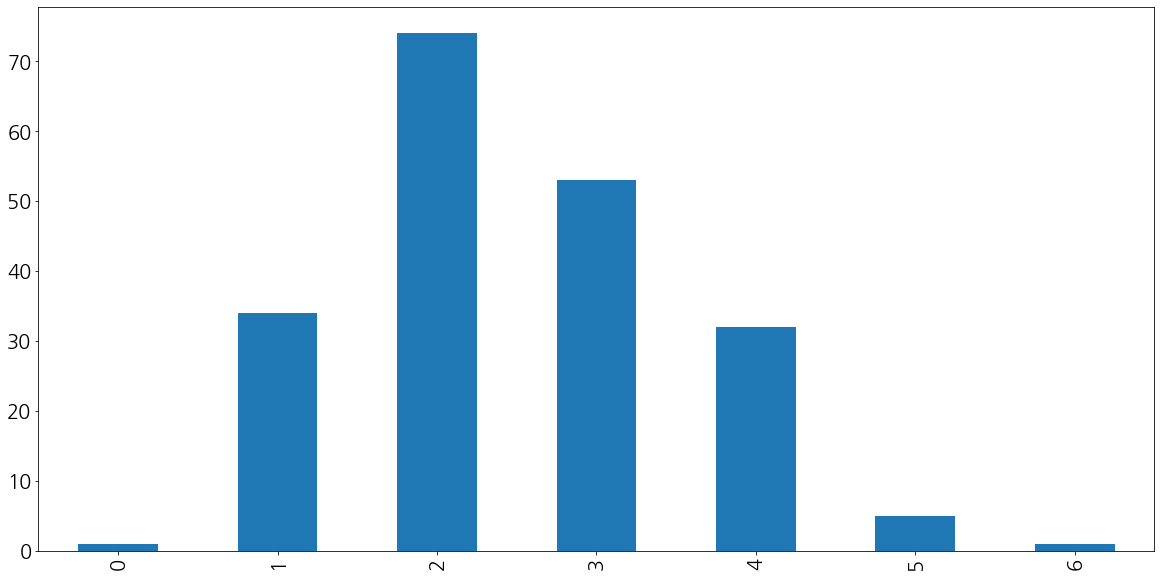

In [70]:
# bar chart로 확인
df_age_count = df_royal_age.groupby(['agegroup'])['purchase_amt'].count().reset_index()
df_age_count['purchase_amt'].plot.bar(figsize=(20,10),fontsize = 20)
print(df_age_count)

### 2019년 4분기 기준 각 등급별 판매 TOP 10

In [82]:
temp = copy.deepcopy(df_rfm)
temp.isnull().sum()

customer_id               0
birth_date                0
gender                    0
age                       0
agegroup                  0
customer_type             0
customer_grade            0
gaip_date                 0
member_month              0
gaip_path                 0
flag_member               0
flag_rcv_sms              0
flag_rcv_email            0
flag_rcv_post             0
zipcode                   0
sigun                     0
dong                      0
purchase_id               0
store_id                  0
purchase_yearmonth        0
purchase_weekday          0
purchase_hour             0
purchase_date             0
purchase_time             0
supply_date               0
item_id                   0
item_g_l                  0
item_g_m                  0
item_g_s                  0
item_name                 0
purchase_cnt              0
unit_cost                 0
purchase_amt              0
recency               23253
frequency             23253
monetary_value      

In [83]:
tmp=temp[['customer_id','gender','agegroup','sigun','purchase_id','store_id',
            'purchase_yearmonth','item_g_l','item_g_m','item_name',
           'purchase_cnt','purchase_amt','Class']]
tmp

,customer_id,gender,agegroup,sigun,purchase_id,store_id,purchase_yearmonth,item_g_l,item_g_m,item_name,purchase_cnt,purchase_amt,Class
0,C118113,여,40대,제주시,C118113_20180110_87,제주매장,2018M01,간식,과자,꼬마찹쌀모나카(112g/8개),1.0,3000.0,NaN
1,C118113,여,40대,제주시,C118113_20180110_87,제주매장,2018M01,양념/가루,장,제주전통어간장(500ml),1.0,7900.0,NaN
2,C118113,여,40대,제주시,C118113_20180110_87,제주매장,2018M01,양념/가루,장,맛간장(900ml),1.0,13600.0,NaN
3,C118113,여,40대,제주시,C118113_20181008_22,제주매장,2018M10,양념/가루,가루,엿기름가루(무/500g),2.0,6400.0,NaN
4,C118113,여,40대,제주시,C118113_20181008_22,제주매장,2018M10,양념/가루,가루,메주가루(500g),2.0,22000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271017,C705016,여,40대,서귀포시,C705016_20191222_46,서귀포매장,2019M12,주곡,멥쌀,백미/유(4kg)-매장용,1.0,15700.0,Platinum
271018,C705016,여,40대,서귀포시,C705016_20191222_46,서귀포매장,2019M12,간식,과자,차례상약과(350g/10개),1.0,8800.0,Platinum
271019,C705016,여,40대,서귀포시,C705016_20191222_46,서귀포매장,2019M12,축산물,유제품,유기농아이스크림(기본형),1.0,8900.0,Platinum
271020,C705016,여,40대,서귀포시,C705016_20191229_51,서귀포매장,2019M12,간식,빵,쌀로만든잉글리쉬머핀(66g×4개)/매장,1.0,3900.0,Platinum


In [99]:
d_set = copy.deepcopy(tmp)

d_set = d_set[d_set['Class'].notnull()]
d_set = d_set[d_set['purchase_cnt'] < 6]
d_set['purchase_cnt'] = d_set['purchase_cnt'].astype(int)

In [100]:
d_set.loc[(d_set["purchase_yearmonth"] == '2018M01') \
         | (d_set["purchase_yearmonth"] == '2018M02')\
         | (d_set["purchase_yearmonth"] == '2018M03'), "bungi"] = "201801"
d_set.loc[(d_set["purchase_yearmonth"] == '2018M04') \
          | (d_set["purchase_yearmonth"] == '2018M05')\
          | (d_set["purchase_yearmonth"] == '2018M06'), "bungi"] = '201802'
d_set.loc[(d_set["purchase_yearmonth"] == '2018M07') \
          | (d_set["purchase_yearmonth"] == '2018M08')\
          | (d_set["purchase_yearmonth"] == '2018M09'), "bungi"] = '201803'
d_set.loc[(d_set["purchase_yearmonth"] == '2018M10') \
          | (d_set["purchase_yearmonth"] == '2018M11')\
          | (d_set["purchase_yearmonth"] == '2018M12'), "bungi"] = '201804'
d_set.loc[(d_set["purchase_yearmonth"] == '2019M01') \
          | (d_set["purchase_yearmonth"] == '2019M02')\
          | (d_set["purchase_yearmonth"] == '2019M03'), "bungi"] = '201901'
d_set.loc[(d_set["purchase_yearmonth"] == '2019M04') \
          | (d_set["purchase_yearmonth"] == '2019M05')\
          | (d_set["purchase_yearmonth"] == '2019M06'), "bungi"] = '201902'
d_set.loc[(d_set["purchase_yearmonth"] == '2019M07') \
          | (d_set["purchase_yearmonth"] == '2019M08')\
          | (d_set["purchase_yearmonth"] == '2019M09'), "bungi"] = '201903'
d_set.loc[(d_set["purchase_yearmonth"] == '2019M10') \
          | (d_set["purchase_yearmonth"] == '2019M11')\
          | (d_set["purchase_yearmonth"] == '2019M12'), "bungi"] = '201904'

##### ROYAL 

In [101]:
d_royal = d_set[d_set['Class'] == 'Royal']

In [102]:
# 2019년 4분기
royal_recent = d_royal[d_royal['bungi']=='201904']

In [103]:
# 구매개수를 기준으로 2019년 4분기 상위 10개
royal_item = royal_recent.groupby(['item_g_l','item_g_m','item_name'])['purchase_cnt']\
            .sum().reset_index().sort_values(by='purchase_cnt', 
                                               ascending = False)
royal_item.head(10)

,item_g_l,item_g_m,item_name,purchase_cnt
257,반찬,두부/유부,두부(1모:420g),282
269,반찬,밑반찬,구운도시락김(5g*3봉),275
256,반찬,두부/유부,두부(1모:400g)참이든-제주,259
484,채소,말린나물/건재,★콩나물(300g),238
260,반찬,두부/유부,마른두부(450g)-제주,193
553,채소,양념채소,★양파(1kg),189
641,채소,잎채소,시금치(300g),183
725,축산물,유정란,유정란(10알/국내산)-제주,175
729,축산물,유정란,유정란/매장용(15알/국내산),163
530,채소,뿌리채소,무(1kg이상),160


##### Platinum 

In [104]:
d_pla = d_set[d_set['Class'] == 'Platinum']
pla_recent = d_pla[d_pla['bungi']=='201904']
pla_item = pla_recent.groupby(['item_g_l','item_g_m','item_name'])['purchase_cnt']\
            .sum().reset_index().sort_values(by='purchase_cnt', 
                                               ascending = False)
pla_item.head(10)

,item_g_l,item_g_m,item_name,purchase_cnt
266,반찬,두부/유부,두부(1모:400g)참이든-제주,366
267,반찬,두부/유부,두부(1모:420g),268
492,채소,말린나물/건재,★콩나물(300g),232
270,반찬,두부/유부,마른두부(450g)-제주,207
727,축산물,유정란,유정란/매장용(안심대안사료/15알),177
722,축산물,유정란,유정란(10알/국내산)-제주,154
280,반찬,밑반찬,구운도시락김(5g*3봉),154
726,축산물,유정란,유정란/매장용(15알/국내산),139
558,채소,양념채소,★양파(1kg),114
732,축산물,유제품,★유기농우유(종이팩/900ml),111


##### Gold 

In [105]:
d_gold = d_set[d_set['Class'] == 'Gold']

gold_recent = d_gold[d_gold['bungi']=='201904']

gold_item = gold_recent.groupby(['item_g_l','item_g_m','item_name'])['purchase_cnt']\
            .sum().reset_index().sort_values(by='purchase_cnt', 
                                               ascending = False)
gold_item.head(10)

,item_g_l,item_g_m,item_name,purchase_cnt
186,반찬,두부/유부,두부(1모:400g)참이든-제주,75
187,반찬,두부/유부,두부(1모:420g),50
358,채소,말린나물/건재,★콩나물(300g),44
197,반찬,밑반찬,구운도시락김(5g*3봉),33
190,반찬,두부/유부,마른두부(450g)-제주,32
46,간식,과자,하늘바다새우(60g),31
491,축산물,유정란,유정란(10알/국내산)-제주,26
16,간식,과자,두부과자(100g),26
406,채소,양념채소,대파(500g),25
402,채소,양념채소,★양파(1kg),24


##### Silver 

In [106]:
d_silver = d_set[d_set['Class'] == 'Silver']

silver_recent = d_silver[d_silver['bungi']=='201904']
silver_item = silver_recent.groupby(['item_g_l','item_g_m','item_name'])['purchase_cnt']\
            .sum().reset_index().sort_values(by='purchase_cnt', 
                                               ascending = False)
silver_item.head(10)

,item_g_l,item_g_m,item_name,purchase_cnt
77,반찬,두부/유부,두부(1모:400g)참이든-제주,15
82,반찬,밑반찬,구운도시락김(5g*3봉),9
153,채소,잎채소,깻잎(30장),8
72,간식,잼/병조림/기타,딸기잼(480g),7
159,채소,잎채소,얼갈이(500g),7
165,축산물,유정란,유정란(10알/국내산)-제주,6
43,간식,밀가공,부숴먹는라면(90g:1봉),6
86,반찬,밑반찬,주먹밥채소&해물(36g),5
51,간식,빵,★크림빵(75g)/매장,5
125,채소,말린나물/건재,★콩나물(300g),5


### 연관규칙

In [113]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

res = copy.deepcopy(d_royal)
tmp = res['bungi'] == '201904' #월 변경 지점
res = res[tmp]
res = res[['purchase_id','item_g_l']]


# 연관규칙 시작
ch = ( res.groupby(['purchase_id'],as_index=False)
           .agg(set))

#ch 확인
ch


,purchase_id,item_g_l
0,C118291_20191010_142,"{양념/가루, 반찬, 채소}"
1,C118291_20191024_78,"{양념/가루, 간식, 채소}"
2,C118291_20191104_15,"{양념/가루, 반찬, 채소}"
3,C118291_20191113_169,"{반찬, 채소}"
4,C118291_20191115_124,{반찬}
...,...,...
3528,C700358_20191209_75,{채소}
3529,C700358_20191212_118,{반찬}
3530,C700358_20191219_89,{축산물}
3531,C700358_20191220_114,"{간식, 반찬}"


In [114]:
enc = TransactionEncoder()
df_enc = enc.fit_transform(X = ch['item_g_l'])

asso = pd.DataFrame(df_enc, columns = enc.columns_)
#asso.head()

v_min_sup = 0.2
freq = apriori(asso, min_support=v_min_sup, use_colnames = True)
#freq 확인
freq.round(3)


,support,itemsets
0,0.488,(간식)
1,0.391,(반찬)
2,0.234,(양념/가루)
3,0.551,(채소)
4,0.453,(축산물)
5,0.250,"(간식, 채소)"
6,0.210,"(축산물, 간식)"
7,0.230,"(반찬, 채소)"
8,0.256,"(축산물, 채소)"


In [115]:
asso_rule = association_rules(freq, metric = "confidence", min_threshold = 0.5)
asso_rule.round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(간식),(채소),0.488,0.551,0.250,0.511,0.928,-0.019,0.919
1,(반찬),(채소),0.391,0.551,0.230,0.589,1.069,0.015,1.092
2,(축산물),(채소),0.453,0.551,0.256,0.566,1.027,0.007,1.035


In [116]:
res = copy.deepcopy(d_royal)
tmp = res['purchase_yearmonth'] == '2019M12' #월 변경 지점
res = res[tmp]
# tmp = res['store_id'] == '제주매장' #월 변경 지점
# res = res[tmp]
res = res[['purchase_id','item_g_l']]


# 연관규칙 시작
ch = ( res.groupby(['purchase_id'],as_index=False)
           .agg(set))

#ch 확인
ch

enc = TransactionEncoder()
df_enc = enc.fit_transform(X = ch['item_g_l'])

asso = pd.DataFrame(df_enc, columns = enc.columns_)
#asso.head()

v_min_sup = 0.1
freq = apriori(asso, min_support=v_min_sup, use_colnames = True)
#freq 확인
freq.round(3)

asso_rule = association_rules(freq, metric = "confidence", min_threshold = 0.1)
asso_rule.round(3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(간식),(반찬),0.482,0.370,0.178,0.370,1.000,0.000,1.000
1,(반찬),(간식),0.370,0.482,0.178,0.482,1.000,0.000,1.000
2,(양념/가루),(간식),0.226,0.482,0.104,0.457,0.948,-0.006,0.953
3,(간식),(양념/가루),0.482,0.226,0.104,0.215,0.948,-0.006,0.985
4,(간식),(채소),0.482,0.526,0.221,0.458,0.871,-0.033,0.875
5,(채소),(간식),0.526,0.482,0.221,0.420,0.871,-0.033,0.892
6,(축산물),(간식),0.413,0.482,0.189,0.459,0.951,-0.010,0.956
7,(간식),(축산물),0.482,0.413,0.189,0.393,0.951,-0.010,0.966
8,(반찬),(채소),0.370,0.526,0.203,0.550,1.046,0.009,1.054
9,(채소),(반찬),0.526,0.370,0.203,0.387,1.046,0.009,1.028


##### 최근 3개월간 Royal 고객의 선호음식 찾기(중분류) 

In [117]:
df_tmp = df_royal[(df_royal['purchase_yearmonth'] == '2019M10') | (df_royal['purchase_yearmonth'] == '2019M11') | (df_royal['purchase_yearmonth'] == '2019M12')]
df_tmp

,customer_id,purchase_id,store_id,purchase_yearmonth,purchase_weekday,purchase_hour,purchase_date,purchase_time,supply_date,item_id,...,purchase_cnt,unit_cost,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
101,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P09040503,...,1,14600,14600,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
102,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05070600,...,1,600,600,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
103,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P10020105,...,1,2100,2100,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
104,C118291,C118291_20191010_142,제주매장,2019M10,목요일,16,2019-10-10,:0:16:54:52,2019-10-10,P05041700,...,1,3400,3400,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
105,C118291,C118291_20191024_78,제주매장,2019M10,목요일,16,2019-10-24,:0:16:11:47,2019-10-24,P09010102,...,1,3500,3500,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270789,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010201,...,1,3300,3300,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270790,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P10010101,...,1,4000,4000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270791,C700358,C700358_20191220_114,제주매장,2019M12,금요일,16,2019-12-20,:0:16:11:36,2019-12-20,P08020203,...,2,3000,6000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal
270792,C700358,C700358_20191230_22,제주매장,2019M12,월요일,11,2019-12-30,:0:11:26:20,2019-12-30,P05030122,...,2,10500,21000,2.0,16.0,274450.0,4.0,4.0,4.0,Royal


In [118]:
# 선호음식
df_item = df_tmp.groupby(['customer_id', 'item_g_l','item_g_m'])['purchase_cnt'].count().reset_index()
df_item

,customer_id,item_g_l,item_g_m,purchase_cnt
0,C118291,간식,과자,1
1,C118291,간식,떡,1
2,C118291,간식,밀가공,1
3,C118291,간식,식사대용,5
4,C118291,반찬,김치,3
...,...,...,...,...
3599,C700358,채소,과일채소,2
3600,C700358,채소,잎채소,2
3601,C700358,축산물,유정란,1
3602,C700358,축산물,유제품,4


In [119]:
# groupby 전 값 미리 확인해보기
df_item[(df_item['customer_id']=='C118291')]

,customer_id,item_g_l,item_g_m,purchase_cnt
0,C118291,간식,과자,1
1,C118291,간식,떡,1
2,C118291,간식,밀가공,1
3,C118291,간식,식사대용,5
4,C118291,반찬,김치,3
5,C118291,반찬,두부/유부,1
6,C118291,반찬,밑반찬,3
7,C118291,반찬,어묵/묵,2
8,C118291,반찬,절임/장아찌,2
9,C118291,양념/가루,가루,2


In [120]:
g_l_list = df_sales["item_g_l"].unique()
g_l_list

array(['간식', '양념/가루', '반찬', '축산물', '채소', '주곡'], dtype=object)

   item_g_m  purchase_cnt
0        과자           730
3         빵           689
2       밀가공           593
1         떡           546
4      식사대용           352
5  잼/병조림/기타            90


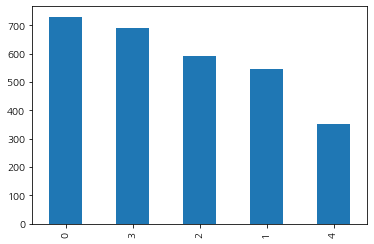

In [121]:
df_tmp = df_item[df_item['item_g_l'] == g_l_list[0]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].head().plot.bar()
print(df_tmp_count)

  item_g_m  purchase_cnt
0       가루           375
3  소스/기타양념           277
4        장           269
1    기름/식초           167
2       소금            30


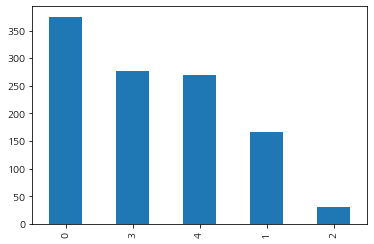

In [122]:
df_tmp = df_item[df_item['item_g_l'] == g_l_list[1]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].plot.bar()
print(df_tmp_count)

  item_g_m  purchase_cnt
1    두부/유부           827
2      밑반찬           464
3     어묵/묵           332
4   절임/장아찌           147
5     즉석조리           132
0       김치            96


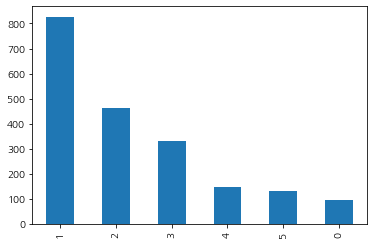

In [123]:

df_tmp = df_item[df_item['item_g_l'] == g_l_list[2]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].plot.bar()
print(df_tmp_count)

  item_g_m  purchase_cnt
5      유제품           623
4      유정란           619
6      육가공           541
7       한우           229
2       돼지           169
1        닭            98
0        꿀            23
3       오리             8


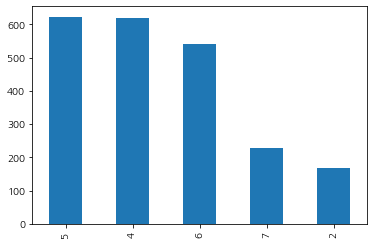

In [124]:
df_tmp = df_item[df_item['item_g_l'] == g_l_list[3]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].head().plot.bar()
print(df_tmp_count)

   item_g_m  purchase_cnt
9       잎채소          1244
6      양념채소           555
4      뿌리채소           501
7      열매채소           466
3        버섯           390
2   말린나물/건재           325
0      과일채소           105
8    잎/줄기채소            90
5      쌈채소류            52
1      김장채소            23
10     특용작물             5


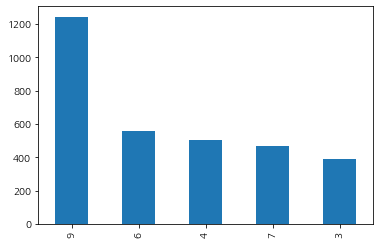

In [125]:
df_tmp = df_item[df_item['item_g_l'] == g_l_list[4]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].head().plot.bar()
print(df_tmp_count)

  item_g_m  purchase_cnt
0       멥쌀           317
1       찹쌀            54


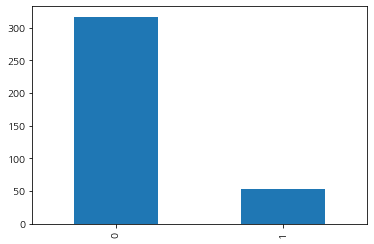

In [126]:
df_tmp = df_item[df_item['item_g_l'] == g_l_list[5]]
# bar chart로 확인
df_tmp_count = df_tmp.groupby(['item_g_m'])['purchase_cnt'].sum().reset_index().sort_values(by='purchase_cnt', ascending = False)
df_tmp_count['purchase_cnt'].plot.bar()
print(df_tmp_count)

### RandomForest 

In [213]:
# 데이터 구성 패키지
import pandas as pd

# 행렬 연산 패키지
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt

# scaling 클래스
from sklearn.preprocessing import scale, minmax_scale, robust_scale

# 분석
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.api import Logit
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Confusion matrix, Accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# 최적 모델, 파라미터 탐색
from sklearn.model_selection import GridSearchCV


# 모델 성능 평가 : F1 Score, ROC Curve, AUC
from sklearn.metrics import f1_score, roc_curve, auc

# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline


In [128]:
df_rfm_rf = copy.deepcopy(df_rfm)
df_rfm_rf['purchase_yearmonth']

0         2018M01
1         2018M01
2         2018M01
3         2018M10
4         2018M10
           ...   
271017    2019M12
271018    2019M12
271019    2019M12
271020    2019M12
271021    2019M12
Name: purchase_yearmonth, Length: 271022, dtype: object

In [155]:
df_sales_filter = df_rfm_rf[(df_rfm_rf["purchase_cnt"] < 6)]
df_sales_1분기=df_sales_filter.query('purchase_yearmonth == "2019M01" | purchase_yearmonth == "2019M02" | purchase_yearmonth == "2019M03"')
df_sales_2분기=df_sales_filter.query('purchase_yearmonth == "2019M04" | purchase_yearmonth == "2019M05" | purchase_yearmonth == "2019M06"')
df_sales_3분기=df_sales_filter.query('purchase_yearmonth == "2019M07" | purchase_yearmonth == "2019M08" | purchase_yearmonth == "2019M09"')
df_sales_4분기=df_sales_filter.query('purchase_yearmonth == "2019M10" | purchase_yearmonth == "2019M11" | purchase_yearmonth == "2019M12"')

df_sales_1분기=df_sales_1분기.drop(['customer_id','birth_date','age','customer_type','customer_grade','member_month','gaip_path',
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                       'gaip_date', 'zipcode', "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_sales_2분기=df_sales_2분기.drop(['customer_id','birth_date','age','customer_type','customer_grade','member_month','gaip_path',
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                       'gaip_date', 'zipcode', "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_sales_3분기=df_sales_3분기.drop(['customer_id','birth_date','age','customer_type','customer_grade','member_month','gaip_path',
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                       'gaip_date', 'zipcode', "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_sales_4분기=df_sales_4분기.drop(['customer_id','birth_date','age','customer_type','customer_grade','member_month','gaip_path',
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                       'gaip_date', 'zipcode', "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)

df_sales_1분기

,gender,agegroup,store_id,purchase_weekday,item_g_m,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,Class
87,여,50대,제주매장,월요일,버섯,600.0,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
88,여,50대,제주매장,월요일,과자,6600.0,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
89,여,50대,제주매장,월요일,한우,13900.0,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
90,여,50대,제주매장,월요일,버섯,3300.0,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
91,여,50대,제주매장,월요일,김치,10900.0,2.0,20.0,412050.0,4.0,4.0,4.0,Royal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266050,여,30대,제주매장,토요일,밑반찬,2600.0,2.0,17.0,300070.0,4.0,4.0,4.0,Royal
266051,여,30대,제주매장,토요일,빵,4000.0,2.0,17.0,300070.0,4.0,4.0,4.0,Royal
266052,여,30대,제주매장,토요일,유정란,7400.0,2.0,17.0,300070.0,4.0,4.0,4.0,Royal
266053,여,30대,제주매장,토요일,기름/식초,15300.0,2.0,17.0,300070.0,4.0,4.0,4.0,Royal


In [157]:
df_sales_1분기_dummy = pd.get_dummies(df_sales_1분기)
df_sales_2분기_dummy = pd.get_dummies(df_sales_2분기)
df_sales_3분기_dummy = pd.get_dummies(df_sales_3분기)
df_sales_4분기_dummy = pd.get_dummies(df_sales_4분기)
# 더미 변수 생성된 데이터의 상위 5개 raw를 확인
df_sales_1분기_dummy = df_sales_1분기_dummy[df_sales_1분기_dummy['recency'].notnull()]
df_sales_2분기_dummy = df_sales_2분기_dummy[df_sales_2분기_dummy['recency'].notnull()]
df_sales_3분기_dummy = df_sales_3분기_dummy[df_sales_3분기_dummy['recency'].notnull()]
df_sales_4분기_dummy = df_sales_4분기_dummy[df_sales_4분기_dummy['recency'].notnull()]

In [140]:
# 목표변수, 설명변수 데이터 지정
df_sales_filter_y = df_sales_1분기_dummy["purchase_amt"]
df_sales_filter_x = df_sales_1분기_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [141]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_sales_filter_x, df_sales_filter_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (17430, 65)
train data Y size : (17430,)
test data X size : (7471, 65)
test data Y size : (7471,)


In [142]:
# 변수명 저장
v_feature_name = df_train_x.columns

rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))


Score on training set : 0.845
Score on test set : 0.326


In [143]:
# 2. 모델 Parameter 조정
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# n_estimatos: 트리수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state = 1234, n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.825,0.279
1,20,0.836,0.308
2,30,0.841,0.317
3,40,0.839,0.319
4,50,0.840,0.325
5,60,0.841,0.327
6,70,0.842,0.327
7,80,0.843,0.326
8,90,0.844,0.326
9,100,0.845,0.326


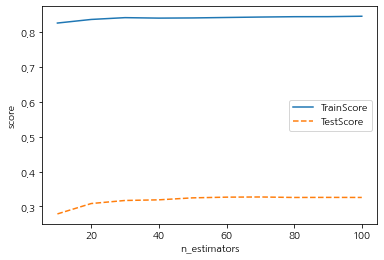

In [144]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [145]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.840,0.325
1,2,0.728,0.354
2,3,0.664,0.357
3,4,0.618,0.358
4,5,0.586,0.355
5,6,0.561,0.348
6,7,0.541,0.342
7,8,0.526,0.339
8,9,0.514,0.336
9,10,0.503,0.336


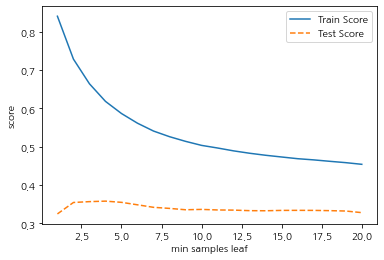

In [146]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [147]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 10,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.503,0.336
1,6,0.503,0.336
2,8,0.503,0.336
3,10,0.503,0.336
4,12,0.503,0.336
5,14,0.503,0.336
6,16,0.503,0.336
7,18,0.503,0.336
8,20,0.503,0.336
9,22,0.500,0.335


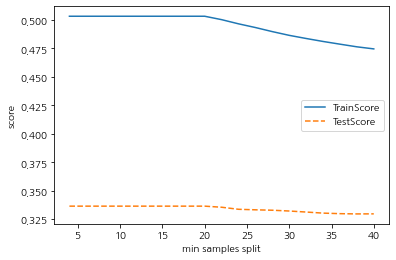

In [148]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [149]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 10,
                                min_samples_split = 20, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.111,0.108
1,2,0.208,0.176
2,3,0.255,0.209
3,4,0.285,0.231
4,5,0.307,0.246
5,6,0.336,0.265
6,7,0.362,0.280
7,8,0.381,0.287
8,9,0.397,0.295
9,10,0.408,0.299


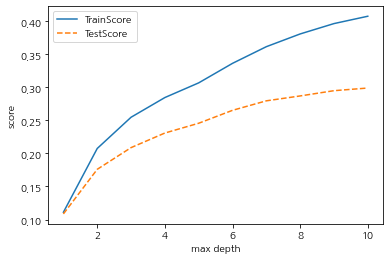

In [150]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [151]:
# 3. 결론 도출
rf_final = RFR(random_state=1234, n_estimators=50, min_samples_leaf=10, min_samples_split=20, max_depth = 4)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.285
Score on test set: 0.231


In [152]:
# 변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3).head(10)

,Feature,Importance
37,item_g_m_멥쌀,0.373
60,item_g_m_한우,0.307
51,item_g_m_육가공,0.085
18,store_id_전화,0.076
30,item_g_m_기름/식초,0.047
54,item_g_m_장,0.047
1,frequency,0.025
2,monetary_value,0.023
0,recency,0.004
23,purchase_weekday_월요일,0.002


Text(0, 0.5, '변수')

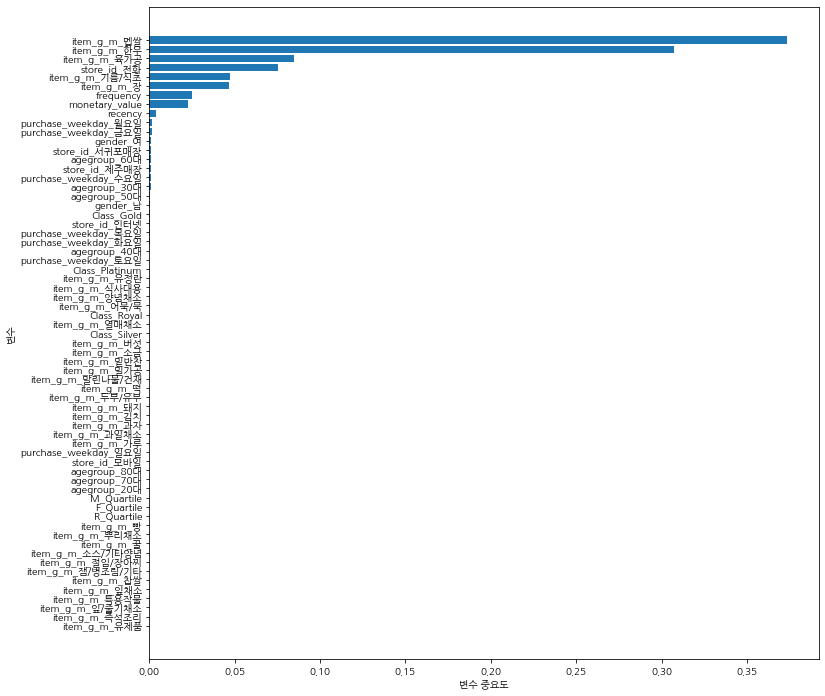

In [153]:
# 설명변수 중요도 그래프. 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])

plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 2분기 

In [158]:
df_sales_2분기_dummy.head()

,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,gender_남,gender_여,agegroup_20대,...,item_g_m_잼/병조림/기타,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
94,21000.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
95,2600.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
96,1300.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
180,9100.0,45.0,2.0,16850.0,1.0,2.0,2.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
181,4400.0,45.0,2.0,16850.0,1.0,2.0,2.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [159]:
# 목표변수, 설명변수 데이터 지정
df_sales_filter_y = df_sales_2분기_dummy["purchase_amt"]
df_sales_filter_x = df_sales_2분기_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [160]:

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_sales_filter_x, df_sales_filter_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))


train data X size : (20770, 67)
train data Y size : (20770,)
test data X size : (8902, 67)
test data Y size : (8902,)


In [161]:

# 변수명 저장
v_feature_name = df_train_x.columns

rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))


Score on training set : 0.868
Score on test set : 0.455


In [162]:
# 2. 모델 Parameter 조정
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# n_estimatos: 트리수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state = 1234, n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.842,0.430
1,20,0.857,0.436
2,30,0.861,0.452
3,40,0.863,0.449
4,50,0.865,0.450
5,60,0.866,0.455
6,70,0.866,0.452
7,80,0.867,0.454
8,90,0.868,0.456
9,100,0.868,0.455


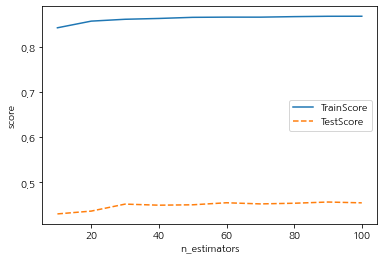

In [163]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [164]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.865,0.450
1,2,0.775,0.486
2,3,0.712,0.475
3,4,0.673,0.483
4,5,0.643,0.491
5,6,0.619,0.491
6,7,0.602,0.489
7,8,0.584,0.485
8,9,0.569,0.479
9,10,0.555,0.473


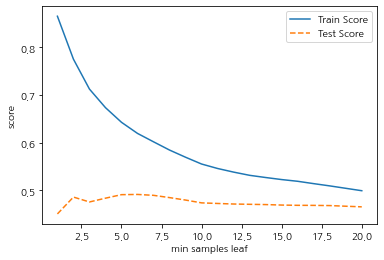

In [165]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [166]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 4,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.673,0.483
1,6,0.673,0.483
2,8,0.673,0.483
3,10,0.660,0.489
4,12,0.646,0.489
5,14,0.634,0.489
6,16,0.625,0.488
7,18,0.611,0.485
8,20,0.600,0.482
9,22,0.590,0.481


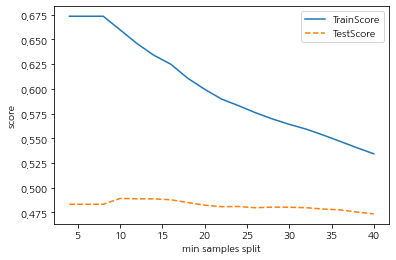

In [167]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [168]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 4,
                                min_samples_split = 10, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.116,0.112
1,2,0.222,0.244
2,3,0.278,0.307
3,4,0.326,0.341
4,5,0.365,0.362
5,6,0.399,0.387
6,7,0.423,0.403
7,8,0.447,0.415
8,9,0.472,0.427
9,10,0.497,0.435


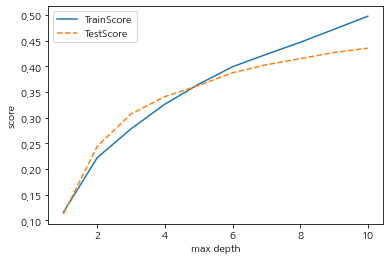

In [169]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [170]:
# 3. 결론 도출
rf_final = RFR(random_state=1234, n_estimators=50, min_samples_leaf=4, min_samples_split=10, max_depth = 3)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.278
Score on test set: 0.307


In [171]:
# 변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3).head(10)

,Feature,Importance
38,item_g_m_멥쌀,0.418
32,item_g_m_꿀,0.235
62,item_g_m_한우,0.196
18,store_id_전화,0.058
1,frequency,0.056
11,agegroup_50대,0.016
23,purchase_weekday_월요일,0.009
2,monetary_value,0.003
0,recency,0.003
26,purchase_weekday_화요일,0.002


Text(0, 0.5, '변수')

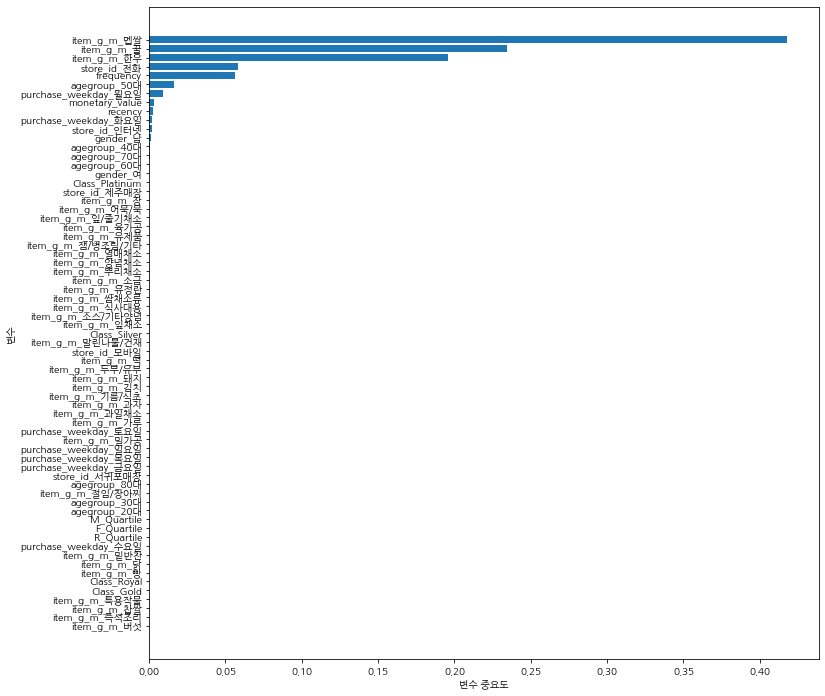

In [172]:
# 설명변수 중요도 그래프. 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])

plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 3분기 

In [174]:
df_sales_3분기_dummy.head()

,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,gender_남,gender_여,agegroup_20대,...,item_g_m_잼/병조림/기타,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
97,1700.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
98,14000.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
99,3400.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
100,10900.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
186,8400.0,45.0,2.0,16850.0,1.0,2.0,2.0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [175]:
# 목표변수, 설명변수 데이터 지정
df_sales_filter_y = df_sales_3분기_dummy["purchase_amt"]
df_sales_filter_x = df_sales_3분기_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [176]:

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_sales_filter_x, df_sales_filter_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))


train data X size : (21926, 69)
train data Y size : (21926,)
test data X size : (9397, 69)
test data Y size : (9397,)


In [177]:

# 변수명 저장
v_feature_name = df_train_x.columns

rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))


Score on training set : 0.883
Score on test set : 0.267


In [178]:
# 2. 모델 Parameter 조정
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# n_estimatos: 트리수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state = 1234, n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.837,0.310
1,20,0.870,0.320
2,30,0.874,0.318
3,40,0.878,0.293
4,50,0.880,0.266
5,60,0.880,0.265
6,70,0.881,0.268
7,80,0.882,0.268
8,90,0.883,0.259
9,100,0.883,0.267


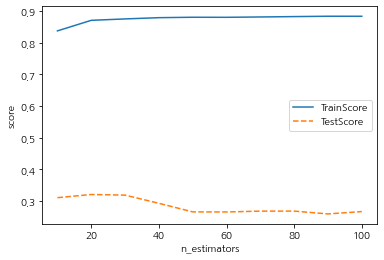

In [179]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [180]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.880,0.266
1,2,0.790,0.264
2,3,0.716,0.220
3,4,0.667,0.154
4,5,0.638,0.114
5,6,0.622,0.172
6,7,0.587,0.319
7,8,0.547,0.368
8,9,0.483,0.372
9,10,0.447,0.360


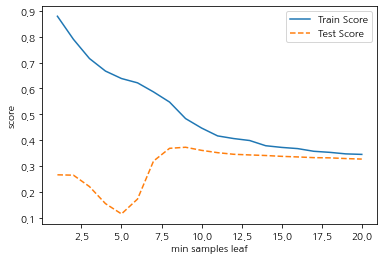

In [181]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [182]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 2,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.790,0.264
1,6,0.763,0.251
2,8,0.729,0.191
3,10,0.700,0.077
4,12,0.688,0.062
5,14,0.679,0.064
6,16,0.671,0.064
7,18,0.664,0.065
8,20,0.655,0.069
9,22,0.645,0.072


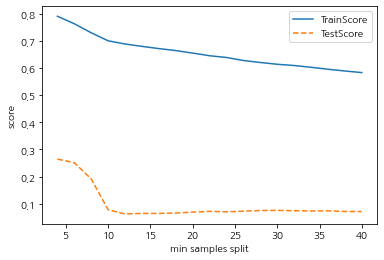

In [183]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [184]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 2,
                                min_samples_split = 8, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.080,0.087
1,2,0.296,0.148
2,3,0.361,0.219
3,4,0.454,0.170
4,5,0.498,0.131
5,6,0.531,0.098
6,7,0.553,0.109
7,8,0.570,0.127
8,9,0.583,0.141
9,10,0.594,0.133


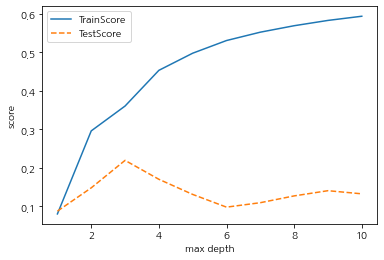

In [185]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [186]:
# 3. 결론 도출
rf_final = RFR(random_state=1234, n_estimators=50, min_samples_leaf=2, min_samples_split=8, max_depth = 4)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.454
Score on test set: 0.170


In [187]:
# 변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3).head(10)

,Feature,Importance
27,item_g_m_가루,0.352
64,item_g_m_한우,0.148
18,store_id_전화,0.134
39,item_g_m_멥쌀,0.126
33,item_g_m_꿀,0.071
1,frequency,0.053
51,item_g_m_열매채소,0.026
55,item_g_m_육가공,0.017
2,monetary_value,0.013
12,agegroup_60대,0.012


Text(0, 0.5, '변수')

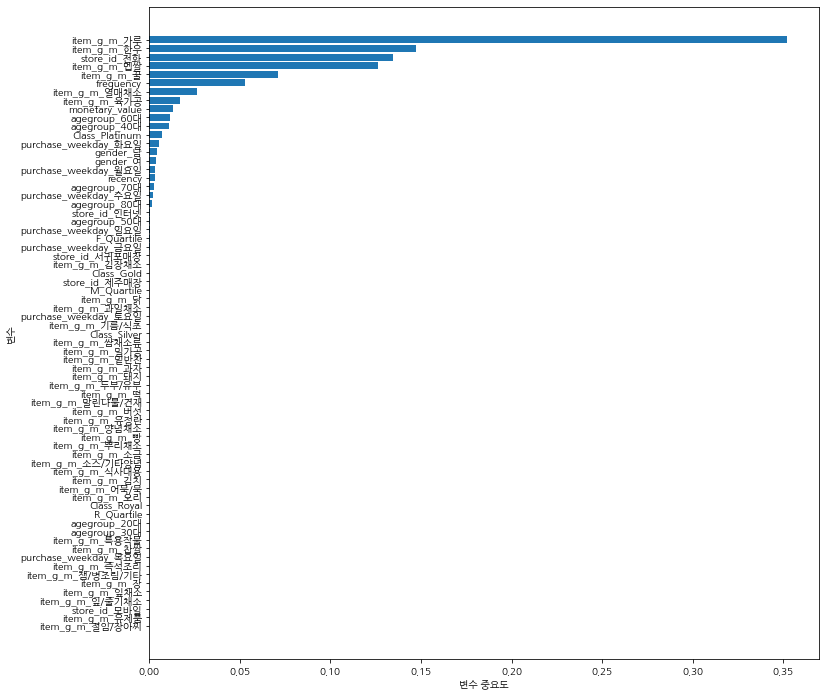

In [188]:
# 설명변수 중요도 그래프. 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])

plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 4분기 

In [189]:
df_sales_4분기_dummy.head()

,purchase_amt,recency,frequency,monetary_value,R_Quartile,F_Quartile,M_Quartile,gender_남,gender_여,agegroup_20대,...,item_g_m_잼/병조림/기타,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
101,14600.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
102,600.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
103,2100.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
104,3400.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
105,3500.0,2.0,20.0,412050.0,4.0,4.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [190]:
# 목표변수, 설명변수 데이터 지정
df_sales_filter_y = df_sales_4분기_dummy["purchase_amt"]
df_sales_filter_x = df_sales_4분기_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [191]:

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_sales_filter_x, df_sales_filter_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))


train data X size : (18461, 69)
train data Y size : (18461,)
test data X size : (7913, 69)
test data Y size : (7913,)


In [192]:

# 변수명 저장
v_feature_name = df_train_x.columns

rf_uncustomized = RFR(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(rf_uncustomized.score(df_test_x, df_test_y)))


Score on training set : 0.827
Score on test set : 0.318


In [193]:
# 2. 모델 Parameter 조정
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# n_estimatos: 트리수 변경: 1~100
para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state = 1234, n_estimators = v_n_estimators)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 결과 저장    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score

# 모델 설명력 확인
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.797,0.273
1,20,0.818,0.296
2,30,0.824,0.298
3,40,0.824,0.298
4,50,0.824,0.310
5,60,0.826,0.317
6,70,0.825,0.323
7,80,0.827,0.320
8,90,0.828,0.321
9,100,0.827,0.318


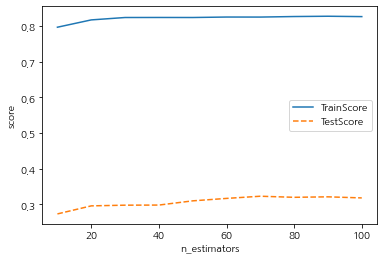

In [194]:
# 모델 설명력 그래프 확인
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [195]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_leaf : 잎사귀 최소 자료 수
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(random_state = 1234,n_estimators = 50, min_samples_leaf = v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))

# 데이터 테이블로 저장    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score

# 모델 설명력 확인
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.824,0.310
1,2,0.716,0.348
2,3,0.647,0.363
3,4,0.590,0.360
4,5,0.551,0.348
5,6,0.527,0.349
6,7,0.506,0.346
7,8,0.488,0.337
8,9,0.469,0.335
9,10,0.452,0.329


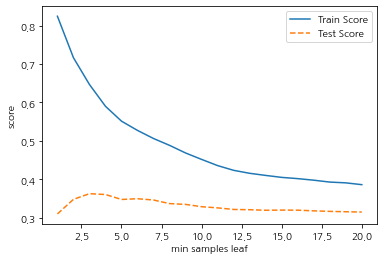

In [196]:
# 모델 설명력 그래프 확인
plt.plot(para_leaf, train_score, linestyle = "-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label="Test Score")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [197]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# min_samples_split : 분할하기 위한 노드의 최소 자료 수
para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                                min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
# 데이터 테이블로 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

# 모델 설명력 확인
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.647,0.363
1,6,0.647,0.363
2,8,0.625,0.365
3,10,0.602,0.360
4,12,0.582,0.355
5,14,0.566,0.352
6,16,0.552,0.353
7,18,0.536,0.352
8,20,0.525,0.346
9,22,0.515,0.344


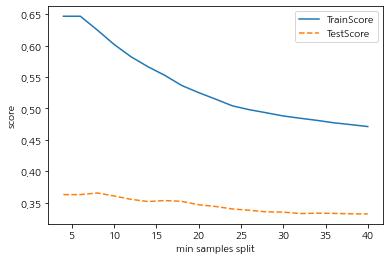

In [198]:
# 모델 설명력 그래프 확인
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [199]:
# train 및 test 설명력 결과 저장
train_score = []
test_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(random_state = 1234, n_estimators = 50, min_samples_leaf = 3,
                                min_samples_split = 15, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

# 모델 설명력 확인
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.101,0.089
1,2,0.155,0.139
2,3,0.201,0.184
3,4,0.229,0.211
4,5,0.279,0.236
5,6,0.322,0.252
6,7,0.362,0.266
7,8,0.393,0.277
8,9,0.413,0.289
9,10,0.429,0.296


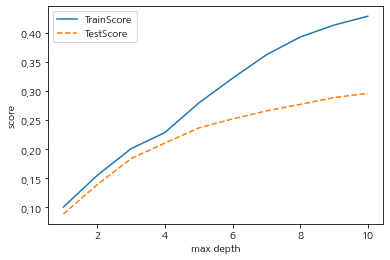

In [200]:
# 모델 설명력 그래프 확인
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [201]:
# 3. 결론 도출
rf_final = RFR(random_state=1234, n_estimators=50, min_samples_leaf=3, min_samples_split=15, max_depth = 3)
rf_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.201
Score on test set: 0.184


In [202]:
# 변수명 저장
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3).head(10)

,Feature,Importance
39,item_g_m_멥쌀,0.391
64,item_g_m_한우,0.365
18,store_id_전화,0.061
55,item_g_m_육가공,0.054
27,item_g_m_가루,0.047
1,frequency,0.046
57,item_g_m_잎채소,0.011
2,monetary_value,0.006
0,recency,0.004
7,gender_여,0.004


Text(0, 0.5, '변수')

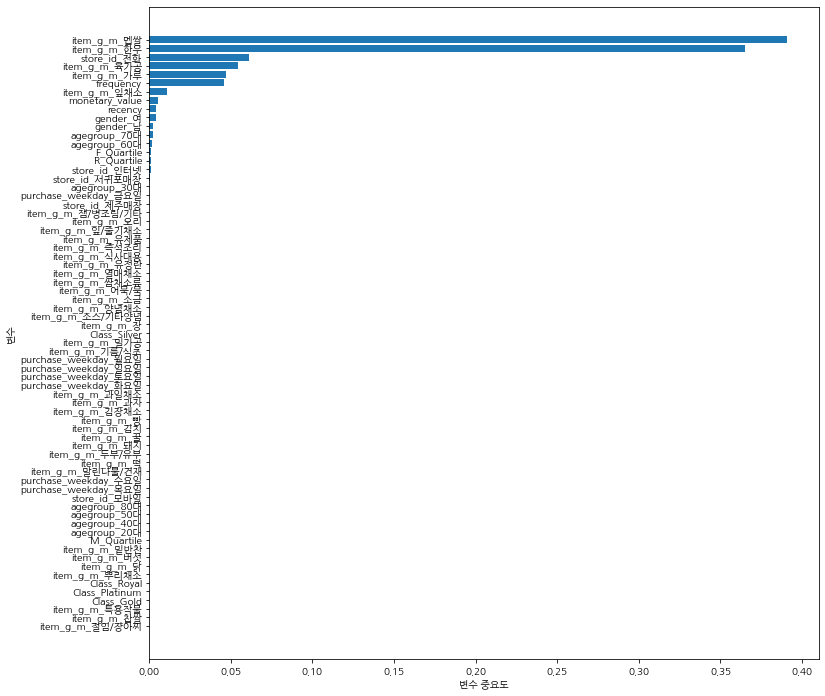

In [203]:
# 설명변수 중요도 그래프. 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])

plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

### 그래디언트 부스팅 

In [204]:
import os
os.environ["PATH"] += os.pathsep + "/home/piai/anaconda3/lib/python3.8/site-packages/graphviz"

In [206]:
# 모든 고객의 구매 내역(없으면 NaN)
df_mge = pd.merge(df_mem, df_sales,on=['customer_id'],how='right')

# 구매내역이 없는 고객일 경우 제거
df_mge = df_mge[df_mge['purchase_amt'].notnull()]

# rfm 적용한 구매내역이 있는 고객
df_rfm = pd.merge(df_mge, rfmSegmentation["Class"],on=['customer_id'],how='left')

df_rfm4 = df_rfm[df_rfm['purchase_date']>='2019-10-01']
df_rfm4.reset_index()

,index,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,...,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt,Class
0,101,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-10-10,P09040503,양념/가루,장,장류/기타,막장(900g),1,14600,14600,Royal
1,102,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-10-10,P05070600,채소,버섯,팽이버섯,★팽이버섯(150g),1,600,600,Royal
2,103,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-10-10,P10020105,반찬,두부/유부,두부,두부(1모:400g)참이든-제주,1,2100,2100,Royal
3,104,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-10-10,P05041700,채소,뿌리채소,우엉,우엉(300g),1,3400,3400,Royal
4,105,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-10-24,P09010102,양념/가루,가루,양념가루,자장가루(100g),1,3500,3500,Royal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26369,271017,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,...,2019-12-22,P01010104,주곡,멥쌀,백미,백미/유(4kg)-매장용,1,15700,15700,Platinum
26370,271018,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,...,2019-12-22,P08010301,간식,과자,한과/유과,차례상약과(350g/10개),1,8800,8800,Platinum
26371,271019,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,...,2019-12-22,P06040300,축산물,유제품,아이스크림,유기농아이스크림(기본형),1,8900,8900,Platinum
26372,271020,C705016,1976-01-23,여,44,40대,일반,Platinum,2019-12-04,1,...,2019-12-29,P08040137,간식,빵,빵,쌀로만든잉글리쉬머핀(66g×4개)/매장,1,3900,3900,Platinum


In [208]:
df_memsales=df_rfm4.drop(['age','customer_type','member_month','gaip_path',"customer_grade",
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                      'birth_date', 'gaip_date', 'zipcode',"customer_id", "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_memsales=df_memsales.fillna(0)
df_memsales.head()

,gender,agegroup,store_id,purchase_weekday,item_g_m,purchase_amt,Class
101,여,50대,제주매장,목요일,장,14600,Royal
102,여,50대,제주매장,목요일,버섯,600,Royal
103,여,50대,제주매장,목요일,두부/유부,2100,Royal
104,여,50대,제주매장,목요일,뿌리채소,3400,Royal
105,여,50대,제주매장,목요일,가루,3500,Royal


In [209]:
df_mem_dummy = pd.get_dummies(df_memsales)
# 더미 변수 생성된 데이터의 상위 5개 raw를 확인
df_mem_dummy.head()

,purchase_amt,gender_남,gender_여,agegroup_20대,agegroup_30대,agegroup_40대,agegroup_50대,agegroup_60대,agegroup_70대,agegroup_80대,...,item_g_m_잼/병조림/기타,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
101,14600,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
102,600,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
103,2100,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
104,3400,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
105,3500,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [210]:
# 목표변수, 설명변수 데이터 지정
df_memsales_y = df_mem_dummy["purchase_amt"]
df_memsales_x = df_mem_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [211]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_memsales_x, df_memsales_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (18461, 63)
train data Y size : (18461,)
test data X size : (7913, 63)
test data Y size : (7913,)


In [214]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.322
Score on test set : 0.277


In [215]:
gb_final=GBR(random_state = 1234)
gb_final.fit(df_train_x, df_train_y)

#Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.322
Score on test set : 0.277


In [216]:
v_feature_name=df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
33,item_g_m_멥쌀,0.227
58,item_g_m_한우,0.216
21,item_g_m_가루,0.054
49,item_g_m_육가공,0.053
51,item_g_m_잎채소,0.047
12,store_id_전화,0.046
52,item_g_m_장,0.036
27,item_g_m_꿀,0.030
24,item_g_m_기름/식초,0.020
29,item_g_m_돼지,0.019


Text(0, 0.5, '변수')

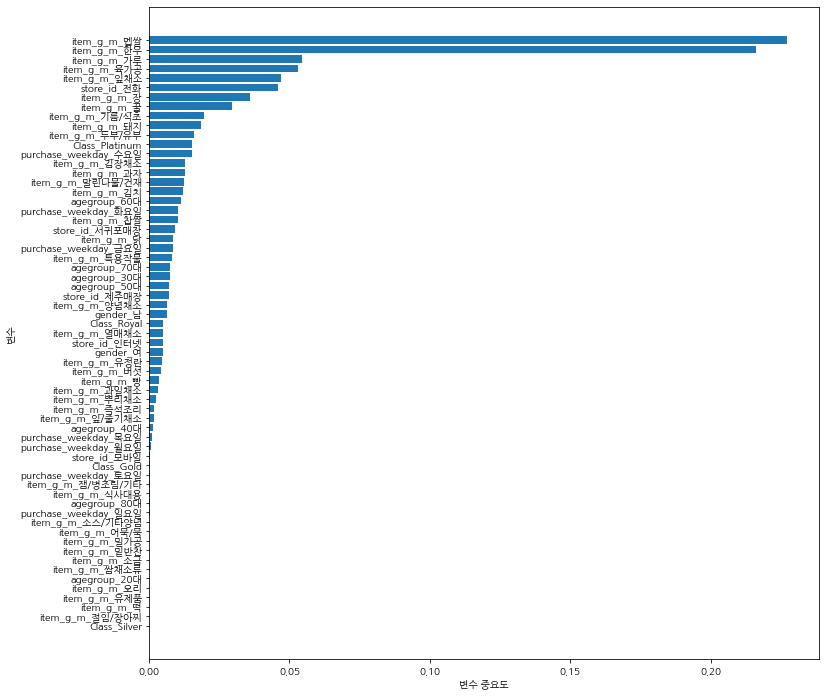

In [217]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 2019년 4분기 

In [219]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.172,0.149
1,20,0.216,0.191
2,30,0.244,0.217
3,40,0.264,0.233
4,50,0.279,0.245
5,60,0.291,0.254
6,70,0.301,0.261
7,80,0.309,0.266
8,90,0.317,0.272
9,100,0.322,0.277


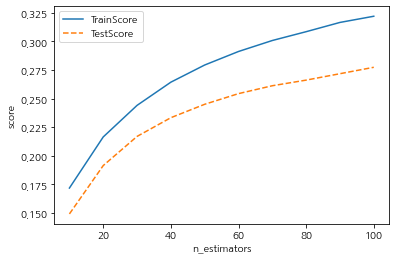

In [220]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [222]:
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state = 1234,n_estimators = 30, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.244,0.217
1,2,0.244,0.217
2,3,0.244,0.217
3,4,0.243,0.215
4,5,0.242,0.217
5,6,0.242,0.217
6,7,0.242,0.217
7,8,0.242,0.216
8,9,0.242,0.216
9,10,0.240,0.215


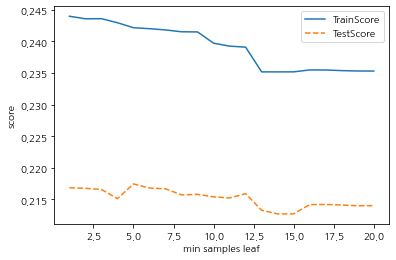

In [223]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_leaf, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [225]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf =5,
                                min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.242,0.217
1,6,0.242,0.217
2,8,0.242,0.217
3,10,0.242,0.217
4,12,0.242,0.217
5,14,0.242,0.217
6,16,0.241,0.216
7,18,0.241,0.216
8,20,0.241,0.217
9,22,0.241,0.217


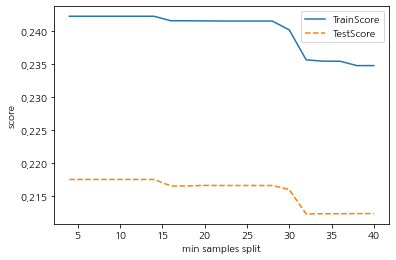

In [226]:
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [227]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.152,0.134
1,2,0.204,0.183
2,3,0.242,0.217
3,4,0.270,0.239
4,5,0.293,0.257
5,6,0.313,0.267
6,7,0.344,0.278
7,8,0.363,0.282
8,9,0.384,0.281
9,10,0.404,0.273


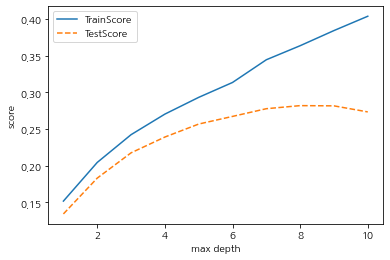

In [228]:
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [229]:
train_score = []
test_score = []

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = 4, learning_rate=v_learning_rate)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.270,0.239
1,0.2,0.321,0.275
2,0.3,0.346,0.294
3,0.4,0.355,0.308
4,0.5,0.363,0.295
5,0.6,0.380,0.296
6,0.7,0.387,0.279
7,0.8,0.393,0.288
8,0.9,0.408,0.272


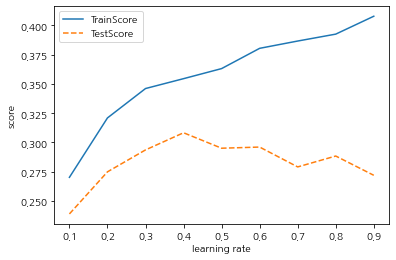

In [230]:
plt.plot(para_lr, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_lr, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

In [231]:
gb_final=GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = 4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

#Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.270
Score on test set : 0.239


In [232]:
v_feature_name=df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
33,item_g_m_멥쌀,0.264
58,item_g_m_한우,0.253
49,item_g_m_육가공,0.058
21,item_g_m_가루,0.057
51,item_g_m_잎채소,0.050
52,item_g_m_장,0.039
12,store_id_전화,0.039
27,item_g_m_꿀,0.030
24,item_g_m_기름/식초,0.019
29,item_g_m_돼지,0.018


Text(0, 0.5, '변수')

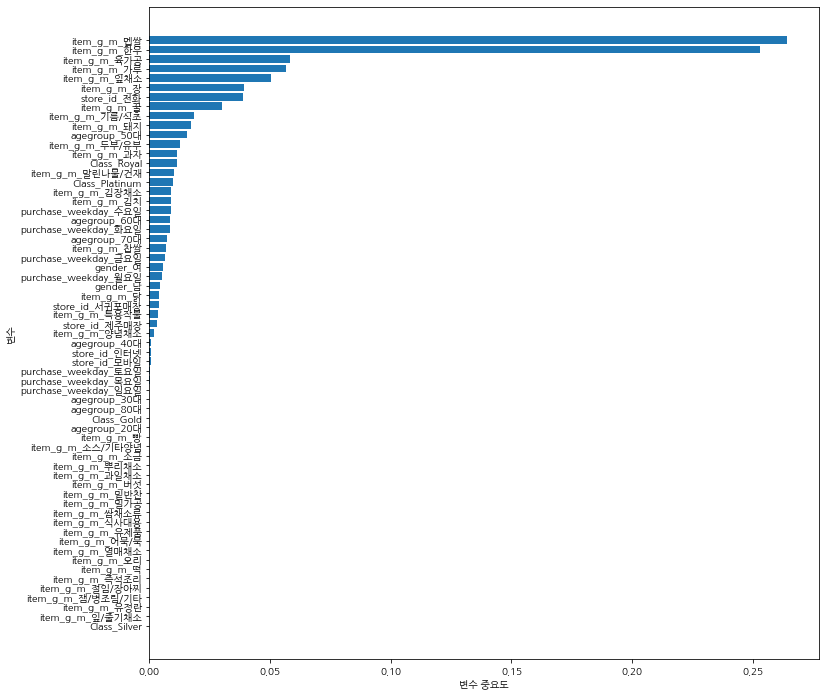

In [233]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 2019년 3분기 

In [297]:
df_rfm3=copy.deepcopy(df_rfm)
df_rfm3=df_rfm3[(df_rfm3['purchase_date']>='2019-07-01')&(df_rfm3['purchase_date']<'2019-10-01')]
df_rfm3.reset_index()

,index,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,...,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt,Class
0,97,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-07-17,P05040600,채소,뿌리채소,당근,당근(500g),1,1700,1700,Royal
1,98,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-07-17,P06020101,축산물,유정란,유정란 안심대안사료,유정란/매장용(안심대안사료/15알),2,7000,14000,Royal
2,99,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-07-17,P05020900,채소,열매채소,단호박,단호박(1개:1~1.5kg),1,3400,3400,Royal
3,100,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-07-17,P10010100,반찬,김치,배추,★백김치(2kg),1,10900,10900,Royal
4,186,C118294,1973-04-19,여,47,40대,일반,Platinum,2011-12-11,97,...,2019-07-22,P06030300,축산물,육가공,한우가공,사골곰국(냉동:1kg),1,8400,8400,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33040,269971,C689361,1984-07-31,여,36,30대,일반,Gold,2019-09-11,4,...,2019-09-26,P05081600,채소,말린나물/건재,콩나물,★콩나물(300g),1,1300,1300,Gold
33041,270006,C691568,1980-01-08,여,40,40대,일반,Gold,2019-09-23,4,...,2019-09-29,P05020900,채소,열매채소,단호박,단호박(1개:0.6~1kg),1,2400,2400,Platinum
33042,270007,C691568,1980-01-08,여,40,40대,일반,Gold,2019-09-23,4,...,2019-09-29,P06010701,축산물,돼지,보리살림돼지,분쇄육(300g/우리보리살림돼지),1,3900,3900,Platinum
33043,270008,C691568,1980-01-08,여,40,40대,일반,Gold,2019-09-23,4,...,2019-09-29,P05050800,채소,양념채소,양파,★양파(1kg),1,2250,2250,Platinum


In [298]:
df_memsales=df_rfm3.drop(['age','customer_type','member_month','gaip_path',"customer_grade",
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                      'birth_date', 'gaip_date', 'zipcode',"customer_id", "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_memsales=df_memsales.fillna(0)
df_memsales.head()

,gender,agegroup,store_id,purchase_weekday,item_g_m,purchase_amt,Class
97,여,50대,제주매장,수요일,뿌리채소,1700,Royal
98,여,50대,제주매장,수요일,유정란,14000,Royal
99,여,50대,제주매장,수요일,열매채소,3400,Royal
100,여,50대,제주매장,수요일,김치,10900,Royal
186,여,40대,서귀포매장,월요일,육가공,8400,Gold


In [299]:
df_mem_dummy = pd.get_dummies(df_memsales)
# 더미 변수 생성된 데이터의 상위 5개 raw를 확인
df_mem_dummy.head()

,purchase_amt,gender_남,gender_여,agegroup_20대,agegroup_30대,agegroup_40대,agegroup_50대,agegroup_60대,agegroup_70대,agegroup_80대,...,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_0,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
97,1700,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
98,14000,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
99,3400,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
100,10900,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
186,8400,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [300]:
# 목표변수, 설명변수 데이터 지정
df_memsales_y = df_mem_dummy["purchase_amt"]
df_memsales_x = df_mem_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [301]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_memsales_x, df_memsales_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (23131, 64)
train data Y size : (23131,)
test data X size : (9914, 64)
test data Y size : (9914,)


In [302]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.468
Score on test set : 0.557


In [303]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.279,0.363
1,20,0.358,0.459
2,30,0.384,0.481
3,40,0.407,0.503
4,50,0.420,0.517
5,60,0.435,0.534
6,70,0.444,0.544
7,80,0.451,0.548
8,90,0.459,0.550
9,100,0.468,0.557


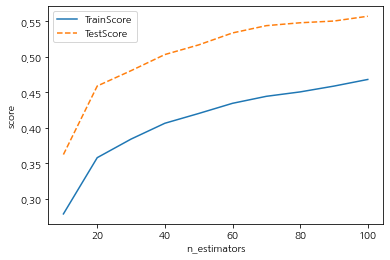

In [304]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [242]:
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state = 1234,n_estimators = 30, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.384,0.481
1,2,0.382,0.481
2,3,0.382,0.481
3,4,0.380,0.481
4,5,0.379,0.482
5,6,0.339,0.418
6,7,0.337,0.408
7,8,0.337,0.407
8,9,0.337,0.407
9,10,0.334,0.407


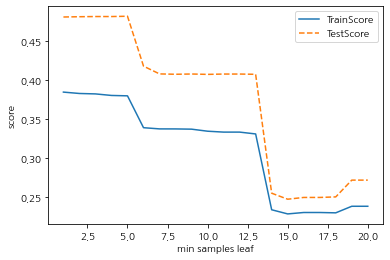

In [243]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_leaf, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [244]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf =5,
                                min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.379,0.482
1,6,0.379,0.482
2,8,0.379,0.482
3,10,0.379,0.482
4,12,0.379,0.482
5,14,0.336,0.407
6,16,0.336,0.407
7,18,0.336,0.407
8,20,0.336,0.407
9,22,0.336,0.407


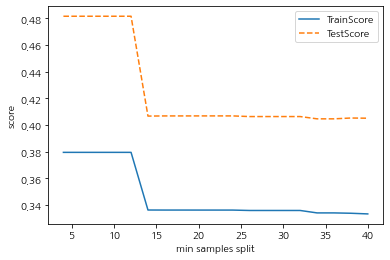

In [245]:
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [247]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.131,0.143
1,2,0.271,0.331
2,3,0.336,0.407
3,4,0.378,0.437
4,5,0.424,0.447
5,6,0.454,0.457
6,7,0.484,0.467
7,8,0.501,0.469
8,9,0.510,0.468
9,10,0.521,0.470


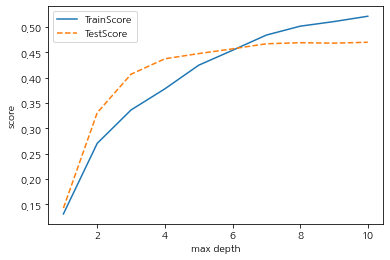

In [248]:
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [250]:
train_score = []
test_score = []

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = 4, learning_rate=v_learning_rate)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.378,0.437
1,0.2,0.428,0.490
2,0.3,0.448,0.513
3,0.4,0.507,0.569
4,0.5,0.466,0.489
5,0.6,0.540,0.554
6,0.7,0.550,0.557
7,0.8,0.583,0.506
8,0.9,0.595,0.521


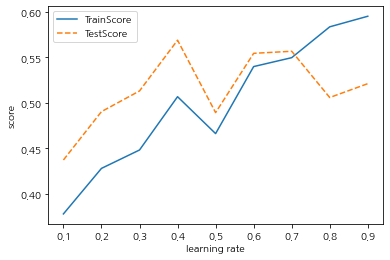

In [251]:
plt.plot(para_lr, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_lr, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

In [252]:
gb_final=GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 5,
                                min_samples_split = 15, max_depth = 4, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

#Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.378
Score on test set : 0.437


In [253]:
v_feature_name=df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
21,item_g_m_가루,0.343
12,store_id_전화,0.146
58,item_g_m_한우,0.132
33,item_g_m_멥쌀,0.113
27,item_g_m_꿀,0.046
49,item_g_m_육가공,0.037
45,item_g_m_열매채소,0.029
24,item_g_m_기름/식초,0.028
62,Class_Royal,0.016
52,item_g_m_장,0.016


Text(0, 0.5, '변수')

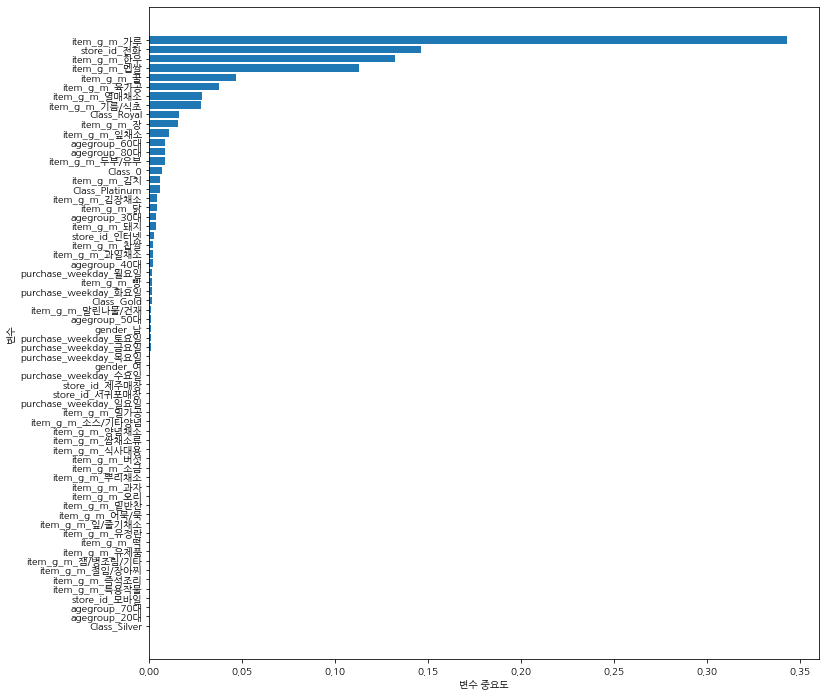

In [254]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 2019년 2분기

In [255]:
df_rfm2=copy.deepcopy(df_rfm)
df_rfm2=df_rfm2[(df_rfm2['purchase_date']>='2019-04-01')&(df_rfm2['purchase_date']<'2019-07-01')]
df_rfm2.reset_index()

,index,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,...,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt,Class
0,94,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-04-10,P08010116,간식,과자,스낵,매일견과(25g*10봉),1,21000,21000,Royal
1,95,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-04-10,P08010103,간식,과자,스낵,오곡퐁(150g),1,2600,2600,Royal
2,96,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-04-10,P08010103,간식,과자,스낵,통밀퐁(70g),1,1300,1300,Royal
3,180,C118294,1973-04-19,여,47,40대,일반,Platinum,2011-12-11,97,...,2019-04-24,P09040100,양념/가루,장,간장,조선간장(900ml),1,9100,9100,Gold
4,181,C118294,1973-04-19,여,47,40대,일반,Platinum,2011-12-11,97,...,2019-04-28,P08010105,간식,과자,스낵,우리밀유정란전병(150g),2,2200,4400,Gold
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31754,268678,C675273,1967-01-09,남,53,50대,일반,Gold,2019-06-23,7,...,2019-07-02,P09010400,양념/가루,가루,과채가루,생강가루(80g),1,15300,15300,Platinum
31755,268679,C675273,1967-01-09,남,53,50대,일반,Gold,2019-06-23,7,...,2019-07-02,P08050100,간식,식사대용,죽,팥죽(230g),2,2100,4200,Platinum
31756,268680,C675273,1967-01-09,남,53,50대,일반,Gold,2019-06-23,7,...,2019-07-02,P09010304,양념/가루,가루,곡식가루,찹쌀가루(500g),1,4200,4200,Platinum
31757,268681,C675273,1967-01-09,남,53,50대,일반,Gold,2019-06-23,7,...,2019-07-02,P05082100,채소,말린나물/건재,삶은무시래기,삶은무시래기(200g),5,1800,9000,Platinum


In [256]:
df_memsales=df_rfm2.drop(['age','customer_type','member_month','gaip_path',"customer_grade",
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                      'birth_date', 'gaip_date', 'zipcode',"customer_id", "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_memsales=df_memsales.fillna(0)
df_memsales.head()

,gender,agegroup,store_id,purchase_weekday,item_g_m,purchase_amt,Class
94,여,50대,제주매장,수요일,과자,21000,Royal
95,여,50대,제주매장,수요일,과자,2600,Royal
96,여,50대,제주매장,수요일,과자,1300,Royal
180,여,40대,서귀포매장,수요일,장,9100,Gold
181,여,40대,서귀포매장,일요일,과자,4400,Gold


In [257]:
df_mem_dummy = pd.get_dummies(df_memsales)
# 더미 변수 생성된 데이터의 상위 5개 raw를 확인
df_mem_dummy.head()

,purchase_amt,gender_남,gender_여,agegroup_20대,agegroup_30대,agegroup_40대,agegroup_50대,agegroup_60대,agegroup_70대,agegroup_80대,...,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_0,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
94,21000,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
95,2600,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
96,1300,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
180,9100,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
181,4400,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [258]:
# 목표변수, 설명변수 데이터 지정
df_memsales_y = df_mem_dummy["purchase_amt"]
df_memsales_x = df_mem_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [259]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_memsales_x, df_memsales_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (22231, 62)
train data Y size : (22231,)
test data X size : (9528, 62)
test data Y size : (9528,)


In [260]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.500
Score on test set : 0.504


In [262]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.276,0.320
1,20,0.356,0.389
2,30,0.404,0.429
3,40,0.433,0.453
4,50,0.451,0.468
5,60,0.468,0.480
6,70,0.479,0.488
7,80,0.487,0.495
8,90,0.494,0.500
9,100,0.500,0.504


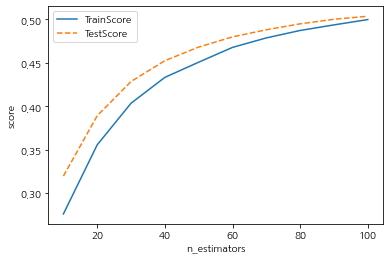

In [263]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [265]:
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state = 1234,n_estimators = 30, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.404,0.429
1,2,0.392,0.430
2,3,0.392,0.430
3,4,0.391,0.427
4,5,0.390,0.425
5,6,0.389,0.426
6,7,0.377,0.390
7,8,0.372,0.384
8,9,0.371,0.383
9,10,0.371,0.383


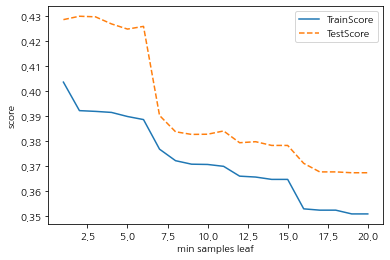

In [266]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_leaf, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [267]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf =7,
                                min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.377,0.390
1,6,0.377,0.390
2,8,0.377,0.390
3,10,0.377,0.390
4,12,0.377,0.390
5,14,0.377,0.390
6,16,0.372,0.384
7,18,0.372,0.384
8,20,0.371,0.384
9,22,0.371,0.384


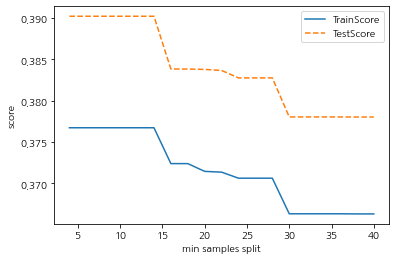

In [268]:
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [269]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 7,
                                min_samples_split = 15, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.222,0.236
1,2,0.315,0.336
2,3,0.377,0.390
3,4,0.421,0.424
4,5,0.449,0.443
5,6,0.470,0.456
6,7,0.490,0.466
7,8,0.505,0.471
8,9,0.519,0.474
9,10,0.532,0.477


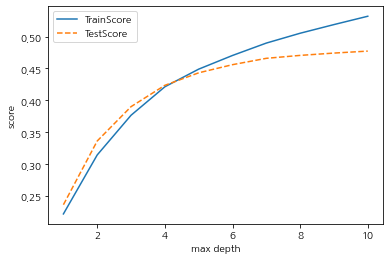

In [270]:
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [271]:
train_score = []
test_score = []

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 7,
                                min_samples_split = 15, max_depth = 2, learning_rate=v_learning_rate)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.315,0.336
1,0.2,0.377,0.401
2,0.3,0.412,0.432
3,0.4,0.432,0.447
4,0.5,0.439,0.462
5,0.6,0.449,0.464
6,0.7,0.458,0.468
7,0.8,0.457,0.465
8,0.9,0.444,0.465


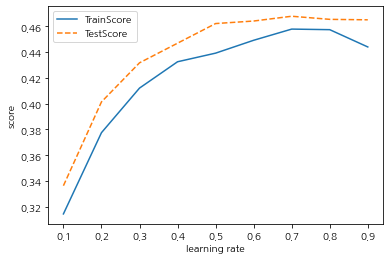

In [272]:
plt.plot(para_lr, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_lr, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

In [273]:
gb_final=GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 7,
                                min_samples_split = 15, max_depth = 2, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

#Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.315
Score on test set : 0.336


In [274]:
v_feature_name=df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
32,item_g_m_멥쌀,0.321
26,item_g_m_꿀,0.255
56,item_g_m_한우,0.143
47,item_g_m_육가공,0.058
12,store_id_전화,0.051
24,item_g_m_기름/식초,0.039
17,purchase_weekday_월요일,0.037
50,item_g_m_장,0.028
22,item_g_m_과일채소,0.026
49,item_g_m_잎채소,0.023


Text(0, 0.5, '변수')

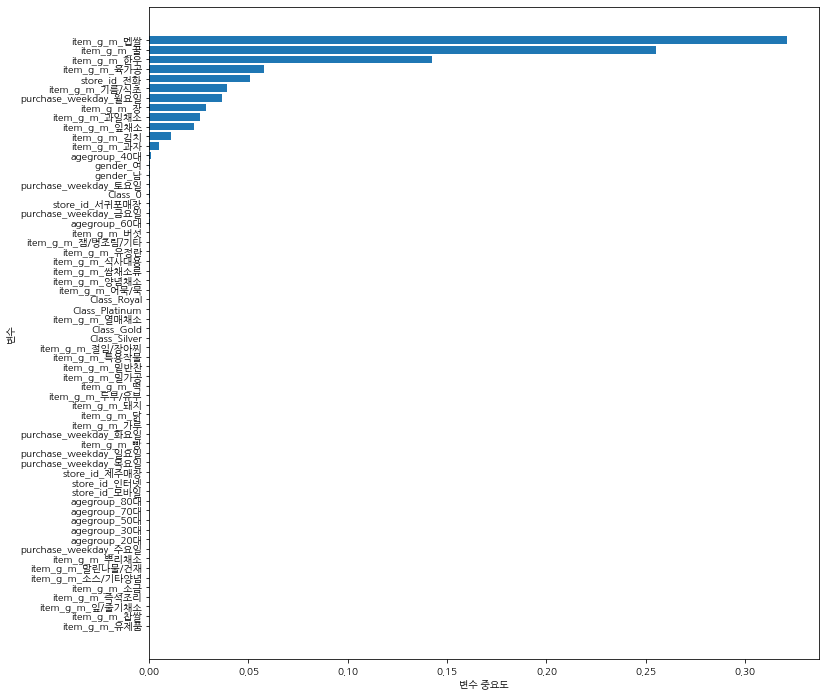

In [275]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

##### 2019년 1분기 

In [276]:
df_rfm1=copy.deepcopy(df_rfm)
df_rfm1=df_rfm1[(df_rfm1['purchase_date']>='2019-01-01')&(df_rfm1['purchase_date']<'2019-04-01')]
df_rfm1.reset_index()

,index,customer_id,birth_date,gender,age,agegroup,customer_type,customer_grade,gaip_date,member_month,...,supply_date,item_id,item_g_l,item_g_m,item_g_s,item_name,purchase_cnt,unit_cost,purchase_amt,Class
0,87,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-01-28,P05070600,채소,버섯,팽이버섯,★팽이버섯(150g),1,600,600,Royal
1,88,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-01-28,P08010118,간식,과자,스낵,누룽지(500g),1,6600,6600,Royal
2,89,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-01-28,P06010402,축산물,한우,유기한우,곱게다진한우순살(유기/200g/국내산),1,13900,13900,Royal
3,90,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-01-28,P05071200,채소,버섯,목이버섯,목이버섯(200g),1,3300,3300,Royal
4,91,C118291,1962-07-19,여,58,50대,일반,Royal,2011-12-11,97,...,2019-01-28,P10010100,반찬,김치,배추,★백김치(2kg),1,10900,10900,Royal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27041,266050,C661797,1982-03-01,여,38,30대,일반,Platinum,2019-03-26,10,...,2019-03-30,P10030501,반찬,밑반찬,김가공,주먹밥채소(36g),1,2600,2600,Royal
27042,266051,C661797,1982-03-01,여,38,30대,일반,Platinum,2019-03-26,10,...,2019-03-30,P08040122,간식,빵,빵,참맛핫도그(200g),1,4000,4000,Royal
27043,266052,C661797,1982-03-01,여,38,30대,일반,Platinum,2019-03-26,10,...,2019-03-30,P06020501,축산물,유정란,유정란,유정란(10알/국내산)-제주,2,3700,7400,Royal
27044,266053,C661797,1982-03-01,여,38,30대,일반,Platinum,2019-03-26,10,...,2019-03-30,P09020101,양념/가루,기름/식초,기름,들기름(330ml),1,15300,15300,Royal


In [277]:
df_memsales=df_rfm1.drop(['age','customer_type','member_month','gaip_path',"customer_grade",
                                      'flag_member','flag_rcv_sms','flag_rcv_email','flag_rcv_post','sigun','dong',
                                      'purchase_yearmonth','purchase_hour','item_g_l',
                                      'birth_date', 'gaip_date', 'zipcode',"customer_id", "purchase_id",
                                      "purchase_date", "purchase_time", "supply_date", "item_id","item_g_s","item_name", 
                                      'unit_cost', 'purchase_cnt'], axis=1, inplace=False)
df_memsales=df_memsales.fillna(0)
df_memsales.head()

,gender,agegroup,store_id,purchase_weekday,item_g_m,purchase_amt,Class
87,여,50대,제주매장,월요일,버섯,600,Royal
88,여,50대,제주매장,월요일,과자,6600,Royal
89,여,50대,제주매장,월요일,한우,13900,Royal
90,여,50대,제주매장,월요일,버섯,3300,Royal
91,여,50대,제주매장,월요일,김치,10900,Royal


In [278]:
df_mem_dummy = pd.get_dummies(df_memsales)
# 더미 변수 생성된 데이터의 상위 5개 raw를 확인
df_mem_dummy.head()

,purchase_amt,gender_남,gender_여,agegroup_20대,agegroup_30대,agegroup_40대,agegroup_50대,agegroup_60대,agegroup_70대,agegroup_80대,...,item_g_m_절임/장아찌,item_g_m_즉석조리,item_g_m_찹쌀,item_g_m_특용작물,item_g_m_한우,Class_0,Class_Gold,Class_Platinum,Class_Royal,Class_Silver
87,600,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
88,6600,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
89,13900,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
90,3300,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
91,10900,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [279]:
# 목표변수, 설명변수 데이터 지정
df_memsales_y = df_mem_dummy["purchase_amt"]
df_memsales_x = df_mem_dummy.drop("purchase_amt", axis = 1, inplace = False)

In [280]:
# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: random seed)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_memsales_x, df_memsales_y, \
                                                               test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (18932, 60)
train data Y size : (18932,)
test data X size : (8114, 60)
test data Y size : (8114,)


In [281]:
gb_uncustomized = GBR(random_state=1234)
gb_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_uncustomized.score(df_train_x, df_train_y)))

# Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_uncustomized.score(df_test_x, df_test_y)))

Score on training set : 0.371
Score on test set : 0.389


In [283]:
train_score = []
test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    gb = GBR(random_state = 1234, n_estimators = v_n_estimators)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.198,0.230
1,20,0.253,0.287
2,30,0.288,0.323
3,40,0.309,0.344
4,50,0.332,0.359
5,60,0.349,0.369
6,70,0.357,0.376
7,80,0.363,0.381
8,90,0.367,0.385
9,100,0.371,0.389


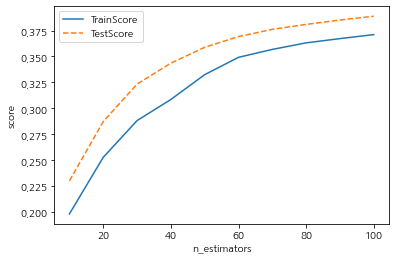

In [284]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("n_estimators")
plt.legend()

In [286]:
train_score = []
test_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GBR(random_state = 1234,n_estimators = 30, min_samples_leaf = v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.288,0.323
1,2,0.288,0.323
2,3,0.288,0.324
3,4,0.287,0.324
4,5,0.287,0.324
5,6,0.284,0.324
6,7,0.282,0.328
7,8,0.282,0.327
8,9,0.272,0.316
9,10,0.272,0.316


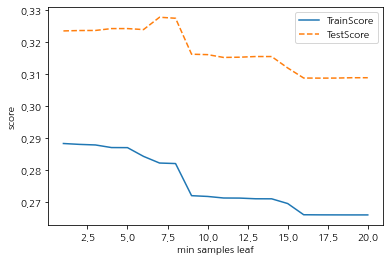

In [287]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_leaf, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples leaf")
plt.legend()

In [288]:
train_score = []
test_score = []

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    gb = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf =8,
                                min_samples_split = v_min_samples_split)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesLeaf"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score
df_score_split.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,4,0.282,0.327
1,6,0.282,0.327
2,8,0.282,0.327
3,10,0.282,0.327
4,12,0.282,0.327
5,14,0.282,0.327
6,16,0.282,0.327
7,18,0.282,0.327
8,20,0.282,0.327
9,22,0.282,0.327


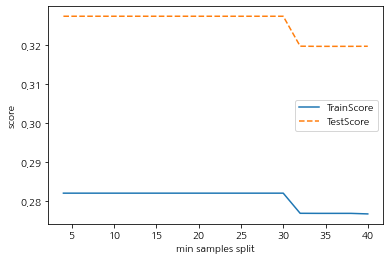

In [289]:
plt.plot(para_split, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_split, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("min samples split")
plt.legend()

In [290]:
train_score = []
test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 8,
                                min_samples_split = 30, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.167,0.197
1,2,0.246,0.287
2,3,0.282,0.327
3,4,0.310,0.349
4,5,0.328,0.364
5,6,0.346,0.373
6,7,0.361,0.377
7,8,0.379,0.380
8,9,0.391,0.376
9,10,0.401,0.377


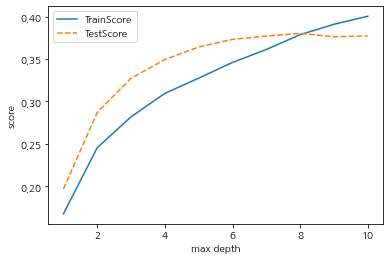

In [291]:
plt.plot(para_depth, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_depth, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("max depth")
plt.legend()

In [292]:
train_score = []
test_score = []

para_lr = [lr*0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    tree = GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 8,
                                min_samples_split = 30, max_depth = 2, learning_rate=v_learning_rate)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
df_score_lr = pd.DataFrame()
df_score_lr["LearningRate"] = para_lr
df_score_lr["TrainScore"] = train_score
df_score_lr["TestScore"] = test_score
df_score_lr.round(3)

,LearningRate,TrainScore,TestScore
0,0.1,0.246,0.287
1,0.2,0.294,0.339
2,0.3,0.317,0.365
3,0.4,0.328,0.379
4,0.5,0.338,0.381
5,0.6,0.342,0.384
6,0.7,0.347,0.386
7,0.8,0.354,0.386
8,0.9,0.356,0.382


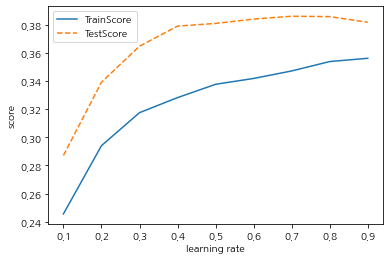

In [293]:
plt.plot(para_lr, train_score, linestyle = "-", label = "TrainScore")
plt.plot(para_lr, test_score, linestyle = "--", label = "TestScore")
plt.ylabel("score")
plt.xlabel("learning rate")
plt.legend()

In [294]:
gb_final=GBR(random_state = 1234, n_estimators = 30, min_samples_leaf = 8,
                                min_samples_split = 30, max_depth = 2, learning_rate=0.1)
gb_final.fit(df_train_x, df_train_y)

#Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
#Test 데이터 설명력
print("Score on test set : {:.3f}".format(gb_final.score(df_test_x, df_test_y)))

Score on training set : 0.246
Score on test set : 0.287


In [295]:
v_feature_name=df_train_x.columns
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

df_importance.sort_values("Importance", ascending = False, inplace = True)
df_importance.round(3).head(10)

,Feature,Importance
31,item_g_m_멥쌀,0.342
54,item_g_m_한우,0.262
12,store_id_전화,0.111
48,item_g_m_장,0.069
45,item_g_m_육가공,0.052
24,item_g_m_기름/식초,0.048
26,item_g_m_꿀,0.037
47,item_g_m_잎채소,0.034
22,item_g_m_과일채소,0.026
28,item_g_m_두부/유부,0.013


Text(0, 0.5, '변수')

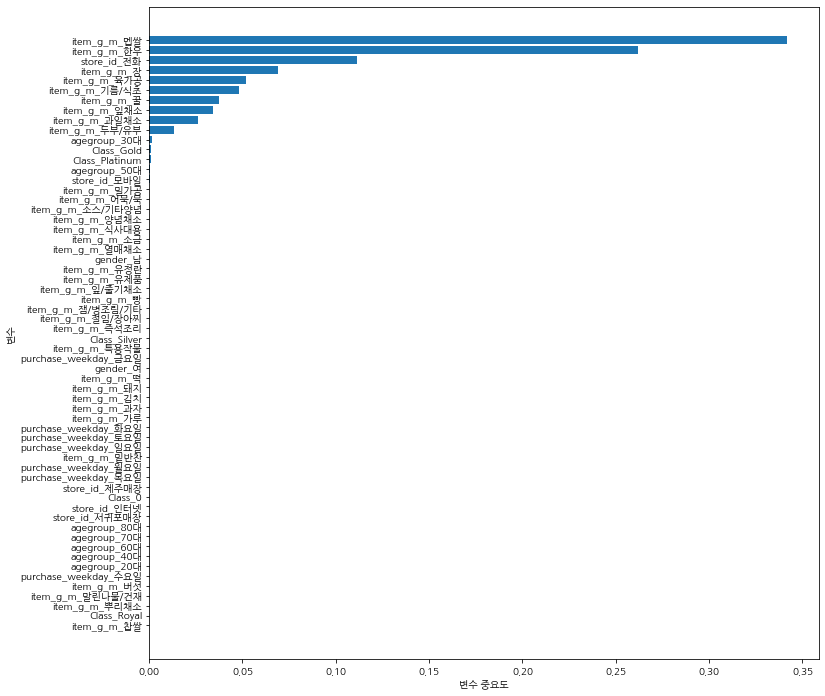

In [296]:
df_importance.sort_values("Importance", ascending = True, inplace = True)
coordinates = range(len(df_importance))
plt.figure(figsize=(12,12))
plt.barh(y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")